In [3]:
import numpy as np
import torch 
import h5py # pour gérer les formats de données utilisés ici 
import matplotlib.pyplot as plt

import random
from tqdm import tqdm
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# TP3: Reconnaissance de signaux de communication par apprentissage profond

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp3.ipynb

2 séances de TP sur ce sujet : le 5 novembre (1h00), le 12 novembre (3h).
Le cours du 19 novembre sera partagé en 3 : cours sur la séparation de sources audio / présentation des mini projets et organisation des soutenances / fin de ce TP.<br>
Deadline pour le rendu du TP: 26 novembre 2025, 13h59, par mail à deepetsignal.mva@gmail.com <br>

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook.
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.

## Problématique

On cherche à identifier un type d'émetteur de communication à partir de l'observation d'un signal provenant de l'émetteur
de 2048 échantillons IQ (In Phase / Quadrature) ie le signal prend des valeurs complexes. On représente la partie
réelle et la partie imaginaire du signal par deux canaux réel d'un signal multivarié.

L'émetteur peut provenir de 6 catégories différentes.
Les paramètres différenciant les différentes catégories sont
- le type de modulation
- la présence ou non de séquences pilotes et le cas échéant la structure de trame pilotes / données
- le débit de la transmission

Les signaux se propagent en champs libre et sont enregistrés par une antenne. Le signal reçu est transposé en bande de base c'est à dire que si le signal est transmis autour d'une fréquence centrale f0, une première étape de traitement du signal à la réception recentre le signal autour de la fréquence 0.


Les différents signaux observés dans ce TP sont entachés de différentes erreurs caractéristiques de la propagation
électromagnétique comme :
- modification aléatoire de la phase du signal lors de la transmission
- imperfection de la transposition en bande de base qui laisse le signal transposé à une fréquence df0 << f0
- présence d'interférence entre les symboles transmis (dûes par exemple à plusieurs chemins de propagation)
- présence d'un bruit blanc additif gaussien

Le niveau du bruit relativement à celui du signal utile est décrit par le SNR (Signal to Noise Ratio) et exprimé en dB. On suppose que le SNR est connu lors de l'acquisition d'un signal. Lors de ce TP nous rencontrerons 4 niveaux de SNR: 30 dB (facile), 20 dB, 10 dB et 0 dB (en espérant qu'on puisse faire quelque chose de ces données).
Un de nos objectifs sera de qualifier la performance des algorithmes mis en place en fonction du SNR.

Les objectifs de ce TP sont:

1. Définir une ou plusieurs architectures de réseaux de neurones profonds et les implémenter en PyTorch
2. Entrainer ces architectures, la fonction de perte employée pourra être la log vraisemblance négative: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html.
3. Qualifier les performances de votre réseau de neurones sur l'ensemble de test via:
   - Le calcul de l'accuracy implémentée par exemple dans le package TorchMetrics (https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html)
   - La réalisation d'un graphique accuracy vs SNR
   - La réalisation des matrices de confusion entre les différentes classes pour les différents SNR (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
4. Rapporter les performances de vos architectures à leur complexité, la complexité d'un réseau de neurones étant ici résumé au nombre de paramètres libres qu'il fait intervenir

Durant l'entraînement on observera l'évolution de la fonction de perte et de l'accuracy sur l'ensemble d'entraînement et sur l'ensemble de validation.


Les 4 premières parties sont un échauffement sur lequel vous pouvez passer vite si vous êtes à l'aise avec le sujet.
Le gros du travail est dans la partie 5 "Entraînemenent d'un réseau de neurones".

Surtout privilégiez dans un premier temps la simplicité quitte à complexifier votre approche ensuite pour doper ses performances. Ne restez pas bloqué sur des réseaux qui "mettent trop de temps à apprendre"

## Chargement des données en numpy

Le TP est composé de trois jeux de données :
- train.hdf5 destiné à nourrir l'entrainement de réseaux de neurones
- test.hdf5 destiné à évaluer les algorithmes après entrainement
- samples.hdf5 qui est beaucoup plus petit que train.hdf5 et destiné à servir de modèle de données dans une phase de prototypage
des algorithmes et de la pipeline d'entrainement

Les trois jeux de données sont au format hdf5 qui peut être manipulé via l'API Python h5py https://docs.h5py.org/en/stable/quick.html.
Un fichier hdf5 est consitué d'une arborescence de datasets et de groups. Un dataset hdf5 représente un tenseur n dimensionnel. Un dataset se convertit très facilement en numpy array.

Par exemple vous pouvez charger les données samples selon la cellule suivante:

In [2]:
# Download data and extract
samples_dir = 'https://cloud.leviia.com/s/ZnIy.FCbmsLANmfaKpbQ/download?path=%2FTP3&files=samples.hdf5'
test_dir = 'https://cloud.leviia.com/s/ZnIy.FCbmsLANmfaKpbQ/download?path=%2FTP3&files=test.hdf5'
train_dir = 'https://cloud.leviia.com/s/ZnIy.FCbmsLANmfaKpbQ/download?path=%2FTP3&files=train.hdf5'
validation_dir = 'https://cloud.leviia.com/s/ZnIy.FCbmsLANmfaKpbQ/download?path=%2FTP3&files=validation.hdf5'

urllib.request.urlretrieve(samples_dir, 'samples.hdf5')
urllib.request.urlretrieve(test_dir, 'test.hdf5')
urllib.request.urlretrieve(train_dir, 'train.hdf5')
urllib.request.urlretrieve(validation_dir, 'validation.hdf5')

('validation.hdf5', <http.client.HTTPMessage at 0x7fd9e669d340>)

In [4]:
sample_data_path = 'train.hdf5'

data = h5py.File(sample_data_path , 'r')

signals = np.array(data['signaux'])
snr =  np.array(data['snr'])
labels_id = np.array(data['labels'])

data.close()

Vous pouvez récupérer le nom de la correspondance entre un label et le nom du standard d'émetteur correspondant via:

In [6]:
def get_labels(open_h5_file):
    return {
        open_h5_file['label_name'].attrs[k] : k
        for k in open_h5_file['label_name'].attrs.keys()
    }

### Visualisation des données

Commencez par étudier les données:

    - observez leur taille
    - la distribution des différentes classes et des différents SNR dans l'ensemble d'entrainement
    - visualisez quelques signaux bien choisis selon une ou des représentations que vous choisirez

Remarque : dans ce TP il n'y a pas beaucoup à gagner à faire du feature engineering

In [7]:
with h5py.File(sample_data_path , 'r') as data:
    signals = np.array(data['signaux'])      # shape: (N, 2, 2048)
    snr = np.array(data['snr'])              # shape: (N,)
    labels_dict = get_labels(data)           # {label_id: label_name, ...}
    labels_id = np.array(data['labels'])     # shape: (N,)
    labels = [labels_dict[id] for id in labels_id] # shape: (N,)

In [6]:
# Observer la taille des données
print("Taille des signaux :", signals.shape)
print("Taille des SNR :", snr.shape)
print("Taille des labels :", labels_id.shape)
print("label dict :", labels_dict)

Taille des signaux : (30000, 2048, 2)
Taille des SNR : (30000,)
Taille des labels : (30000,)
label dict : {np.int64(1): 'N-PSK8', np.int64(0): 'N-QAM16', np.int64(2): 'N-QPSK', np.int64(4): 'W-PSK8-V1', np.int64(5): 'W-PSK8-V2', np.int64(3): 'W-QAM16'}


In [8]:
# Quicker (but ugly) way to choose one signal per label..
for i, lbl_id in enumerate(labels_id[:25]):
    print(i, lbl_id) 

# So let's pick these signals for visualization:
# chosen_signals = [11, 15, 0, 3, 6, 14]  # one signal index per label id (for sample.hdf5)
chosen_signals = [12, 18, 3, 6, 10, 15]  # one signal index per label id (for train.hdf5)

0 4
1 3
2 3
3 5
4 3
5 5
6 2
7 4
8 2
9 2
10 1
11 5
12 4
13 4
14 2
15 0
16 2
17 2
18 3
19 0
20 2
21 0
22 4
23 0
24 5


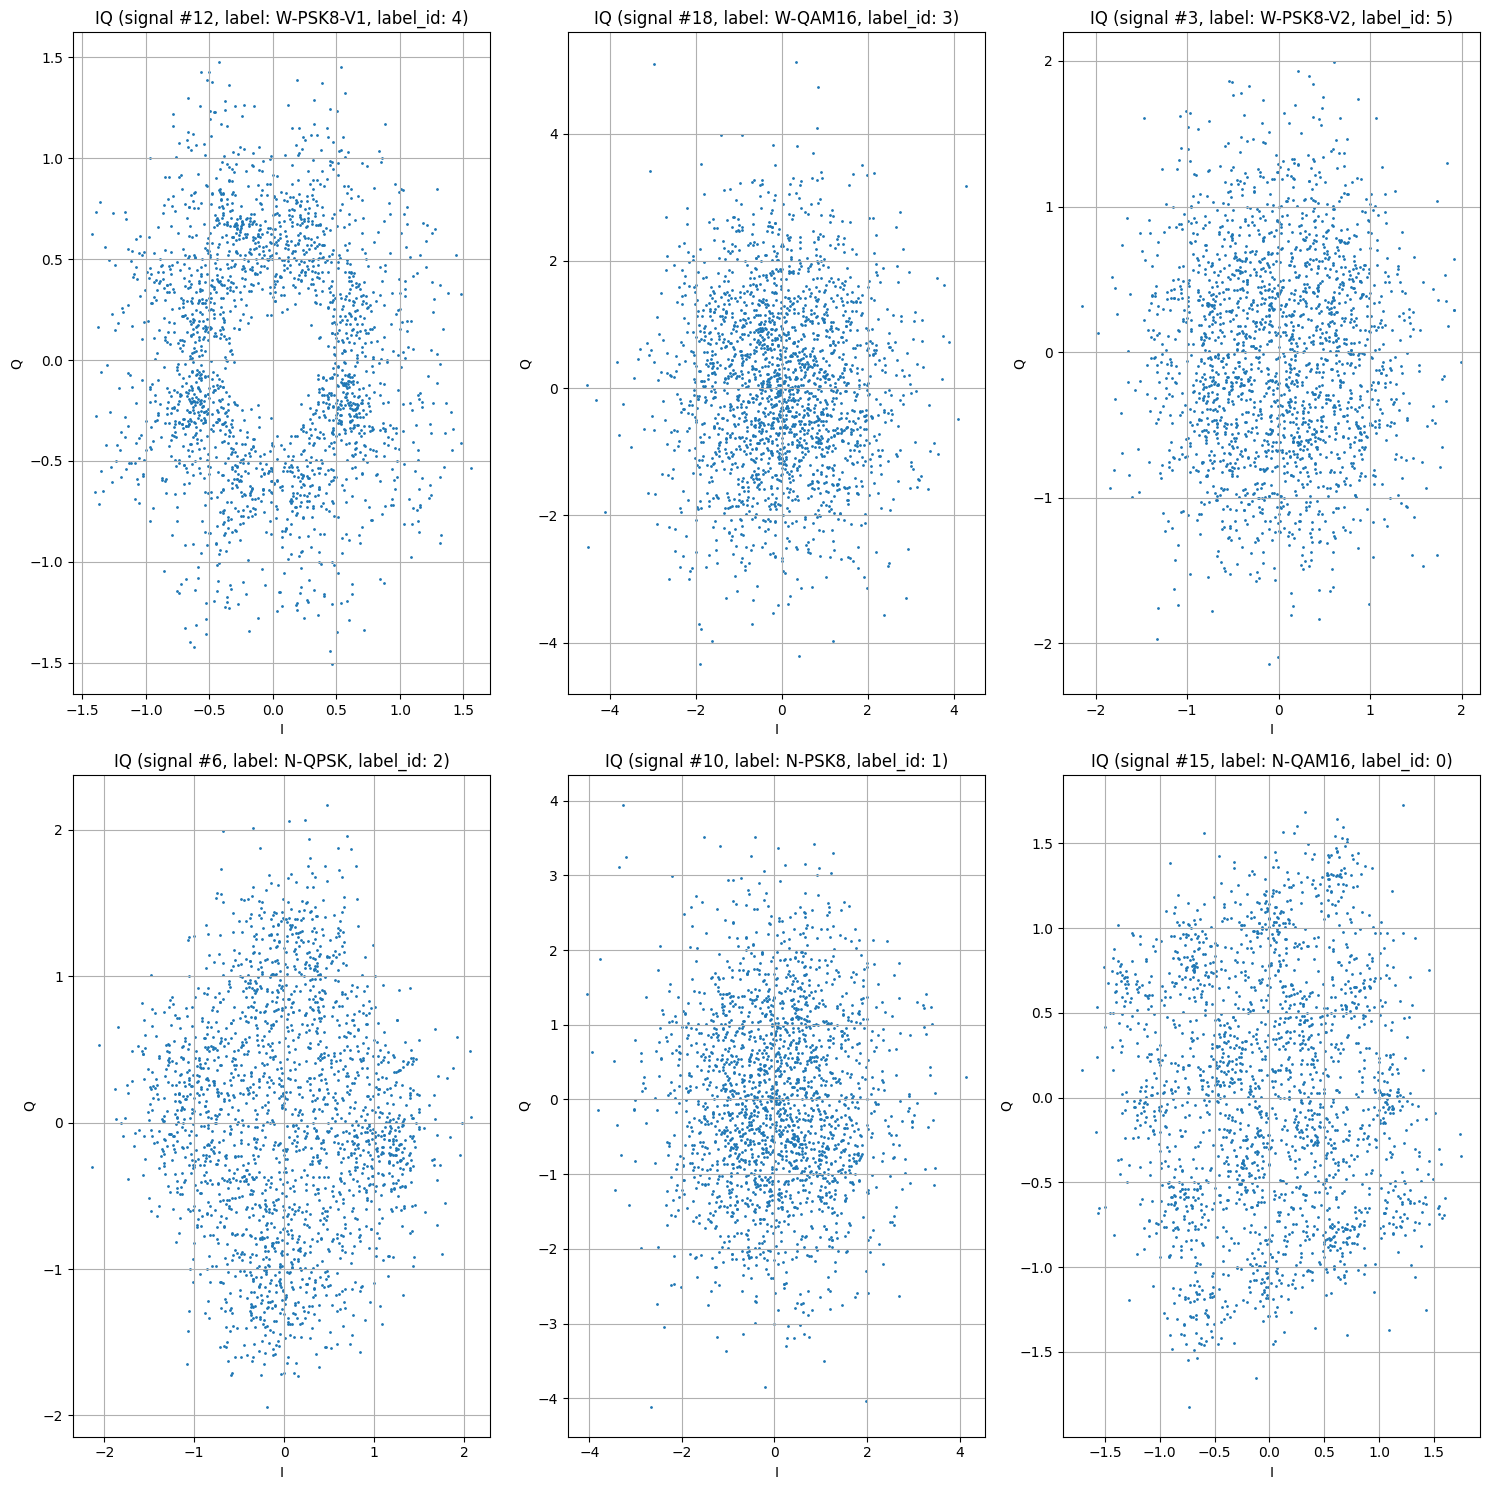

In [8]:
# One signal I/Q per class
plt.figure(figsize=(15, 15))
for i, sig in enumerate(chosen_signals):
    idx = i  # ou choisir des indices spécifiques
    plt.subplot(2, 3, i+1)
    plt.scatter(signals[sig, :, 0], signals[sig, :, 1], s=1)
    plt.title(f"IQ (signal #{sig}, label: {labels_dict[labels_id[sig]]}, label_id: {labels_id[sig]})")
    plt.xlabel("I")
    plt.ylabel("Q")
    plt.grid(True)
plt.tight_layout()
plt.show()


<h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>

We observe three main classes that seem easy to differentiate. Let's plot some samples of the label_id 0 (N-QAM16) to see to intra-class variability. 

<hr style="border:10px solid blue"> </hr>
</font></h4>

(5143,)
(5143, 2048, 2)


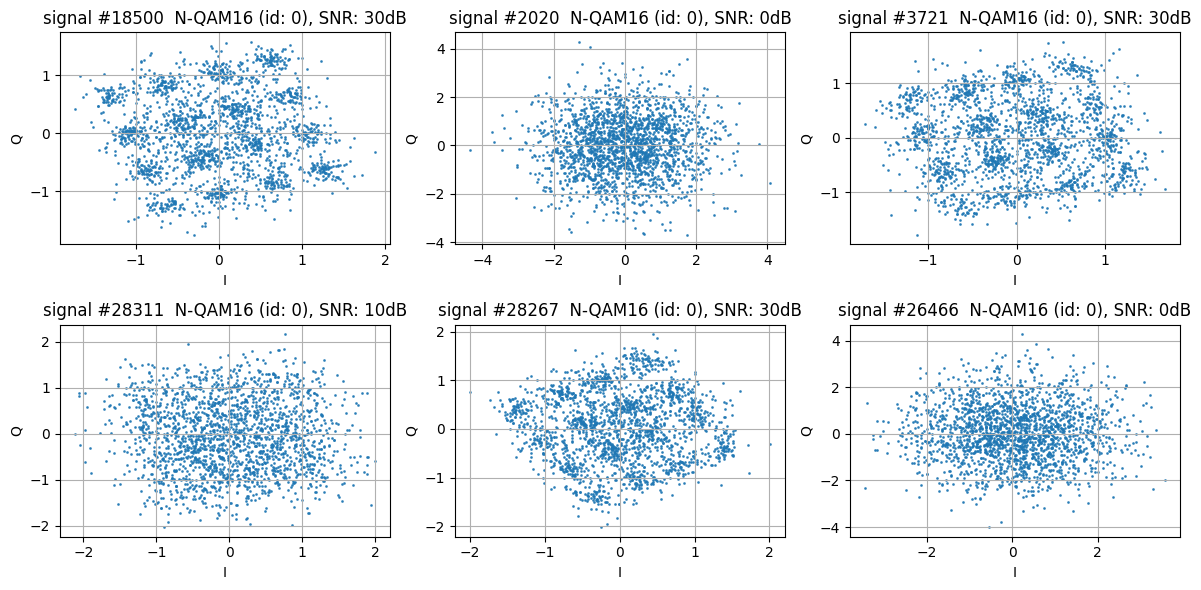

In [9]:
# Modulation: N-QAM16 (Label 0)
idxs_label0 = np.where(labels_id == 0)[0]
print(idxs_label0.shape)
signals_label0 = signals[idxs_label0]

# deterministic shuffle (change seed or remove for randomness)
rng = np.random.default_rng()
perm = rng.permutation(len(idxs_label0))

# shuffled
idxs_label0 = idxs_label0[perm]
signals_label0 = signals_label0[perm]

# take the first 
print(signals_label0.shape)
# show 6 IQ plots for label 0 (Modulation: N-QAM16)
n_show = 6
plt.figure(figsize=(12, 6))
for i in range(n_show):
    idx = int(idxs_label0[i])
    sig = signals[idx]
    plt.subplot(2, 3, i+1)
    plt.scatter(sig[:, 0], sig[:, 1], s=1, alpha=0.8)
    plt.title(f"signal #{idx}  N-QAM16 (id: 0), SNR: {snr[idx]}dB")
    plt.xlabel("I"); plt.ylabel("Q"); plt.grid(True)
plt.tight_layout()
plt.show()



<h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>

On this example, we can observe several examples of the N-QAM16 modulation. We see that high SNRs give recognizable patterns, but low SNRs (0dB, 10dB) don't enable to distinguish something or classify the signal by just looking. 

<hr style="border:10px solid blue"> </hr>
</font></h4>

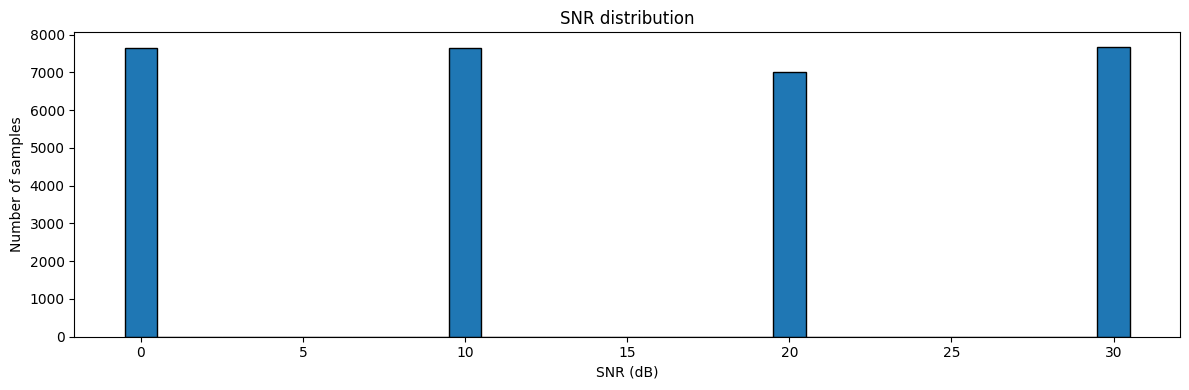

In [10]:
# Distribution des SNR au global
plt.figure(figsize=(12, 4))
bins = np.arange(snr.min(), snr.max() + 2) - 0.5  # discrete SNR bins (e.g. 0,10,20,30)

plt.hist(snr, bins=bins, color='tab:blue', edgecolor='k')
plt.xlabel("SNR (dB)")
plt.ylabel("Number of samples")
plt.title("SNR distribution")
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Class distribution')

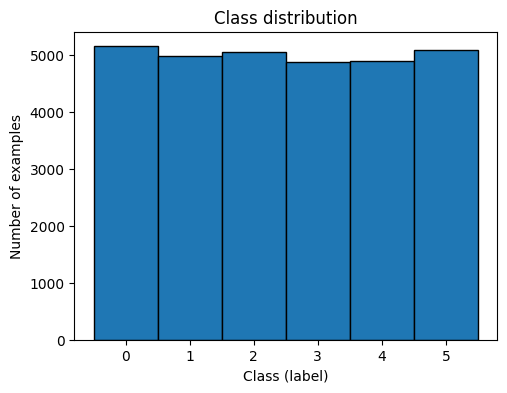

In [14]:
# Distribution des classes et des SNR
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(labels_id, bins=np.arange(labels_id.min(), labels_id.max()+2)-0.5, color='tab:blue', edgecolor='k')
plt.xlabel("Class (label)")
plt.ylabel("Number of examples")
plt.title("Class distribution")

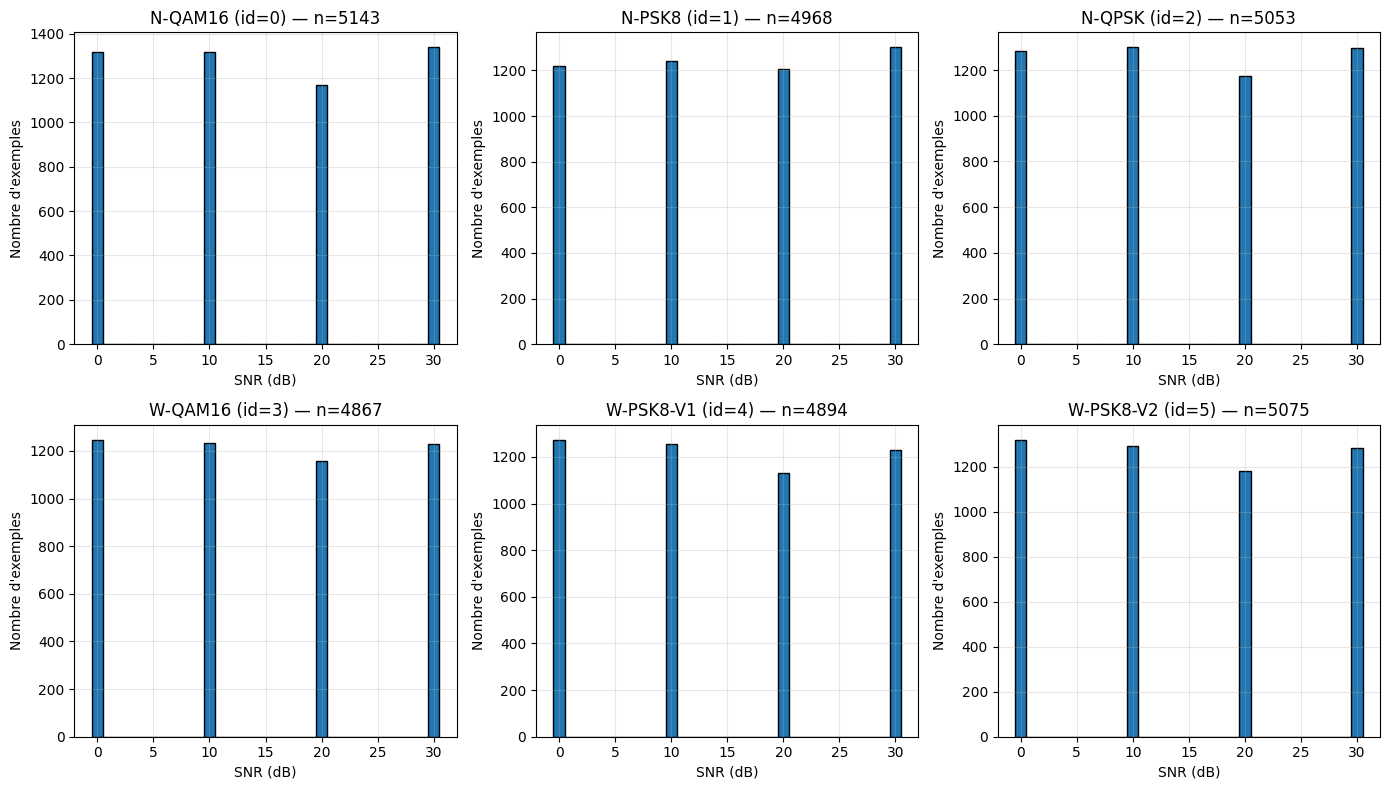

In [15]:
# SNR distribution per class
unique_labels = np.unique(labels_id)
n_labels = unique_labels.size
nrows, ncols = 2, 3

fig, axes = plt.subplots(nrows, ncols, figsize=(14, 8))
axes = axes.flatten()

bins = np.arange(snr.min(), snr.max() + 2) - 0.5  # discrete SNR bins (e.g. 0,10,20,30)

for ax, label_id in zip(axes, unique_labels):
    snr_for_label = snr[labels_id == label_id]
    plt.sca(ax)  # make ax the current axis so plt.hist draws into it
    plt.hist(snr_for_label, bins=bins, color='tab:blue', edgecolor='k')
    plt.title(f"{labels_dict[label_id]} (id={label_id}) — n={snr_for_label.size}")
    plt.xlabel("SNR (dB)")
    plt.ylabel("Nombre d'exemples")
    # plt.xticks(np.unique(snr))
    plt.grid(alpha=0.3)

# hide extra axes if any
for ax in axes[n_labels:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


<h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>

The dataset is quite balanced (in both class distributions and SNRs distribution), it means that we can use classification without bothering of weighting some classes or sample in a certain way to make this equilibrate. Indeed, it's important to have a balanced dataset in order to have each class enough represented in the model compared to other. 

<hr style="border:10px solid blue"> </hr>
</font></h4>

## Chargement des données en Pytorch

Pour entrainer des réseaux de neurones profond sur nos données nous allons utiliser le framework Pytorch.
Une première étape va consister à transférer les données de numpy à PyTorch, cela passe par deux objets :
    - un Dataset qui modélise le dataset à haut niveau dans la mémoire de l'ordinateur
    - un Dataloader qui permet d'échantillonner le Dataset Pytorch dans les itérations de l'optimisation du réseau de neurones
    
Un dataset prend la forme
```python
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, path_to_data):
        ...
    def __len__(self): #retourne le nombre de données dans le dataset
        ...
    def __getitem__(self,i): #retourne pour chaque indice i un couple (data_i, label_i), data_i étant un signal et label_i le label associé au signal
        ...
```

Implémentez une classe Dataset pour le dataset considéré ici

In [17]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, path_to_data):
        with h5py.File(path_to_data, 'r') as data:
            self.signals = np.array(data['signaux'])      # shape: (N, 2, 2048)
            self.labels = np.array(data['labels'])        # shape: (N,)

        # Ensure shape is (N, C, T) = (N, 2, 2048)
        if self.signals.shape[1] == 2:
            # Already (N, 2, T)
            self.signals = self.signals
        elif self.signals.shape[-1] == 2:
            # (N, T, 2) -> (N, 2, T)
            self.signals = np.transpose(self.signals, (0, 2, 1))
        else:
            raise ValueError(f"Unexpected signals shape {self.signals.shape}, cannot find channel dimension 2.")

        # Conversion en tensors pour PyTorch
        self.signals = torch.tensor(self.signals, dtype=torch.float32)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):
        return self.signals[i], self.labels[i]

Instanciez un objet dataset et testez le sur les données samples
```python
dataset = MyDataset(...)
```

In [7]:
dataset = MyDataset(sample_data_path)
x0 = dataset[0]  # Premier signal
print("Signal shape:", x0[0].shape)
x1 = dataset[1]  # Deuxième signal
print("Signal shape:", x1[0].shape)

Signal shape: torch.Size([2, 2048])
Signal shape: torch.Size([2, 2048])


Pytorch propose une classe Dataloader qui permet d'échantillonner des batchs de taille fixe à partir d'un dataset.
La cellule suivante donne un exemple d'utilisation

In [8]:
dataloader = DataLoader(dataset,
                        batch_size=10,
                        shuffle=True
                       )

Testez le dataloader pour différentes valeurs de batch_size

In [9]:
# Iterate on the DataLoader
for batch_idx, (signals_batch, labels_batch) in enumerate(dataloader):
    print(f"Batch {batch_idx}:")
    print("  Signals batch shape:", signals_batch.shape)
    print("  Labels batch shape:", labels_batch.shape)
    if batch_idx == 2:
        break

Batch 0:
  Signals batch shape: torch.Size([10, 2, 2048])
  Labels batch shape: torch.Size([10])
Batch 1:
  Signals batch shape: torch.Size([10, 2, 2048])
  Labels batch shape: torch.Size([10])
Batch 2:
  Signals batch shape: torch.Size([10, 2, 2048])
  Labels batch shape: torch.Size([10])


## Mise en place d'un réseau "dumb" pour tester la pipeline d'entrainement

Définissez un premier modèle Pytorch qui prend en entrée un batch de données (tenseur de dimensions [B , C, T] avec B la taille du batch, C le nombre de canaux des signaux et T le nombre d'échantillons dans les signaux) et renvoie un batch de vecteur de probabilités (ou de log probabilités si vous préférez) (tenseur de dimensions [B,N] où N est le nombre de classe à identifier).

Ce modèle doit comporter moins de 10000 paramètres libres.

Ce Modèle doit être très simple, il doit être rapide à exécuter, il servira à tester et éventuellement débugger la pipeline d'entrainement que vous mettrez en place un peu plus loin. Un template d'implémentation d'une classe Model se trouve dans les diapositives du cours.

In [10]:
class DumbModel(torch.nn.Module):
    def __init__(self, in_channels, n_classes=6):
        super(DumbModel, self).__init__()
        self.fc = torch.nn.Linear(in_channels, n_classes)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        # x: [B, C, T]
        x = x.mean(dim=-1)  # [B, C]
        x = self.fc(x)      # [B, n_classes]
        x = self.softmax(x)
        return x

Instanciez votre modèle et testez la consistence des dimensions de ses entrées et de ses sorties vis à vis des données étudiées. Il s'agit d'un test purement fonctionnel, pas besoin de chercher à réaliser un entraînement à ce point.

In [11]:
dumb_model = DumbModel(in_channels=2, n_classes=6)
# Do a pass with batch of data to test dimensions
signals_batch, labels_batch = next(iter(dataloader))
print("Signals batch shape:", signals_batch.shape)  # [B, 2, 2048]
outputs = dumb_model(signals_batch)
print("Output shape:", outputs.shape)  # [B, n_classes]

Signals batch shape: torch.Size([10, 2, 2048])
Output shape: torch.Size([10, 6])


Estimez par un calcul "théorique" le nombre de paramètres du modèle que vous avez défini et vérifié que le modèle a bien ce nombre de paramètres en pratique par exemple en utilisant la fonction suivante :

In [12]:
def count_n_param(model):
    return sum([p.numel() for p in model.parameters()])

In [13]:
n_params_dumb = count_n_param(dumb_model)
print("Number of parameters in DumbModel:", n_params_dumb)

Number of parameters in DumbModel: 18


## Mise en place de la pipeline d'entraînement

La pipeline d'entrainement consiste à
- charger les données
- les batcher
- réaliser des itération (epochs) de descente de gradient pour optimiser les paramètres d'un algorithme selon une fonction de perte (loss)
- logger l'évolution au fil des epochs  de la loss sur l'ensemble train et l'ensemble de validation et éventuellement de métriques complémentaires

Un cavnevas d'implémentation pourrait être:

```python
device = 'cpu' # set so 'cuda:xx' if you have a GPU, xx is GPU index. L'entraînement des réseaux de neurones est grandement accéléré par l'utilisation d'un GPU

model = ...  # vous instanciez ici votre modèle

loss = .... # définissez la fonction de perte selon laquelle le modèle sera optimisé

optimizer = torch.optim.Adam(model.parameters()) # en pratique on utilise pas une simple descente de gradient mais une procédure d'optimisation plus sophistiquée qui est implémentée sous la forme d'un objet Optimizer. Il en existe beaucoup d'optimizers différents, vous pouvez en tester différents, je vous propose d'utiliser en premier lieu l'algorithme Adam

n_epochs = ... # le nombre d'itérations dans l'entrainement

chemin_vers_sauvegarde_model = # chemin vers un fichier où vous sauvegarderez votre modèle après optimisation pour le réutiliser plus tard.

model.to(device) # on place le modèle dans le GPU si nécessaire

for epoch in range(n_epochs):
    
    for batch_x,batch_y in dataloader_train:
        
        batch_x.to(device)
        batch_y.to(device)
        
        optimizer.zero_grad()
        
        batch_y_predicted = model(batch_x)
        
        l = loss(batch_y_predicted, batch_y)
        # loggez la loss sur le batch d'entraînement
        
        l.backward()
        
        optimizer.step()
        
    for batch_x,batch_y in dataloader_valid:
        
        batch_x.to(device)
        batch_y.to(device)
        
        with torch.no_grad():
            batch_y_predicted = model(batch_x)  
            
        # loggez la loss et les métriques sur le batch de validation

torch.save(model, chemin_vers_sauvegarde_model)

```

Mettez en place votre pipeline et testez là sur votre modèle dumb. Faites en sorte que votre façon de logger les loss et les métriques vous permette de visualiser l'évolution de ces différents indicateurs sur l'ensemble d'entrainement et de validation au fil des epochs.

In [14]:
# Load full dataset
train_data_path = "train.hdf5"
full_dataset = MyDataset(train_data_path)

# We use a validation ratio of 20%
validation_ratio = 0.2
n_total   = len(full_dataset)
n_val     = int(n_total * validation_ratio)
n_train   = n_total - n_val
# Random split training and validation
train_dataset, valid_dataset = random_split(full_dataset, [n_train, n_val])

# Define batch size and create data loaders
batch_size = 64
dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# Model parameters
n_classes   = 6
in_channels = 2

# Initialize model, loss function, optimizer
model = DumbModel(in_channels=in_channels, n_classes=n_classes)
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model_path = "dumb_model.pth"
model.to(device)

def batch_accuracy(log_probs, targets):
    preds = log_probs.argmax(dim=-1)
    return (preds == targets).float().mean().item()

train_losses = []
valid_losses = []
train_accs   = []
valid_accs   = []
n_epochs = 20
for epoch in range(n_epochs):

    # Training loop
    model.train()
    running_loss_train = 0.0
    running_acc_train  = 0.0
    n_train_samples    = 0

    for batch_x, batch_y in dataloader_train:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()

        batch_y_predicted = model(batch_x)
        l = loss_fn(batch_y_predicted, batch_y)

        l.backward()
        optimizer.step()

        # logging
        batch_size = batch_x.size(0)
        running_loss_train += l.item() * batch_size
        running_acc_train  += batch_accuracy(batch_y_predicted, batch_y) * batch_size
        n_train_samples    += batch_size

    epoch_train_loss = running_loss_train / n_train_samples
    epoch_train_acc  = running_acc_train  / n_train_samples
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    # Validation loop
    if epoch == 0 or (epoch + 1) % 5 == 0:
        model.eval()
        running_loss_valid = 0.0
        running_acc_valid  = 0.0
        n_valid_samples    = 0

        with torch.no_grad():
            for batch_x, batch_y in dataloader_valid:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)

                batch_y_predicted = model(batch_x)
                l = loss_fn(batch_y_predicted, batch_y)

                batch_size = batch_x.size(0)
                running_loss_valid += l.item() * batch_size
                running_acc_valid  += batch_accuracy(batch_y_predicted, batch_y) * batch_size
                n_valid_samples    += batch_size

        epoch_valid_loss = running_loss_valid / n_valid_samples
        epoch_valid_acc  = running_acc_valid  / n_valid_samples
        valid_losses.append(epoch_valid_loss)
        valid_accs.append(epoch_valid_acc)

        print(
            f"Epoch {epoch}/{n_epochs} | "
            f"train_loss={epoch_train_loss:.4f}, valid_loss={epoch_valid_loss:.4f}, "
            f"train_acc={epoch_train_acc:.4f}, valid_acc={epoch_valid_acc:.4f}"
        )

# Sauvegarde du modèle
torch.save(model, model_path)
print("Model saved to:", model_path)

Using device: cuda
Epoch 0/20 | train_loss=1.8289, valid_loss=1.8044, train_acc=0.1658, valid_acc=0.1645
Epoch 4/20 | train_loss=1.7916, valid_loss=1.7920, train_acc=0.1690, valid_acc=0.1593
Epoch 9/20 | train_loss=1.7915, valid_loss=1.7922, train_acc=0.1718, valid_acc=0.1612
Epoch 14/20 | train_loss=1.7915, valid_loss=1.7920, train_acc=0.1717, valid_acc=0.1637
Epoch 19/20 | train_loss=1.7914, valid_loss=1.7921, train_acc=0.1728, valid_acc=0.1662
Model saved to: dumb_model.pth


Vérifiez que vous avez bien enregistré votre modèle en fin d'entrainement. Chargez le avec la fonction
```python
modele = torch.load(...)
```
et vérifiez que vous pouvez l'utiliser sur des données du problème.

In [16]:
loaded_model = torch.load(model_path, map_location=device, weights_only=False)
loaded_model.to(device)
loaded_model.eval()

# Take a batch from your dataloader (train or valid)
signals_batch, labels_batch = next(iter(dataloader_valid))
signals_batch = signals_batch.to(device)
labels_batch  = labels_batch.to(device)

with torch.no_grad():
    outputs = loaded_model(signals_batch)

print("Signals batch shape:", signals_batch.shape)
print("Outputs shape:", outputs.shape)

# Checking some 'predictions'
preds = outputs.argmax(dim=-1)
print("Predictions:", preds[:10].cpu().numpy())
print("True labels:", labels_batch[:10].cpu().numpy())

Signals batch shape: torch.Size([64, 2, 2048])
Outputs shape: torch.Size([64, 6])
Predictions: [0 0 0 0 5 0 5 0 0 0]
True labels: [4 1 4 2 3 4 2 2 4 4]


## Entraînement de réseaux de neurones

Dans cette partie vous définissez une ou si vous avancez suffisamment vite plusieurs architecture de réseaux de neurones profonds et vous les réglez sur les données d'entrainement.
Vous pouvez notamment utiliser des réseaux à base de convolutions et/ou de couches réurrentes. Vous pouvez vous inspirer de ce qui a été dit en cours sur la reconnaissance vocale.

Dans un deuxième temps, si vous le souhaitez vous pouvez tenter de mettre en place des stratégies autour de l'utilisation des données d'entraînement pour améliorer vos résultats. Si vous cherchez à mettre en place de l'augmentation de données vous pouvez vous renseigner sur l'argument collate_fn du dataloader standard de Pytorch.

As we have saw in the lecture about vocal recognition, there are three stages that comprise the signal classification:
- Temporal feature extraction
- Temporal dimension contraction
- Classification

We also saw that the loss function used is normally the negative log likelihood.

**Design of our Convolutional NN architecture**
For the temporal **feature extraction** we will use 1D convolutional layers, by stacking several convs with the ReLU activation function. The idea is that the first conv layers behave like local time-frequency filters while deeper conv layers will comine them to form more abstract patterns (as it was done for speech).

After temporal feature extraction we must reduce the time dimension by pooling. There are two approaches for this:
- Local contraction using `MaxPool1d(kernel_size=2)` after each conv layer, so that there is a local temporal downsampling.
- Global contaction (using `x.mean(dim=-1)`).
For this architecture we will use the latter.

For the classification layer we will just use a MLP followed by a softmax.

In [17]:
"""
Iteration 1:
- Small kernel size
- Channels per layer [16, 32, 64]
- Smaller dense layer
"""
class ConvModel(nn.Module):
    def __init__(self, in_channels=2, n_classes=6):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(in_channels, 16, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, n_classes)

    def forward(self, x):
        # CONVOLUTIONAL BLOCK
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        # DONWNSAMPLING BLOCK
        x = x.mean(dim=-1)

        # CLASSIFICATION BLOCK
        x = F.relu(self.fc1(x))
        # x = self.dropout(x)
        x = self.fc2(x)
        return x

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# Model parameters
n_classes   = 6
in_channels = 2

# Initialize model, loss function, optimizer
model = ConvModel(in_channels=in_channels, n_classes=n_classes)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

model_path = "conv1_model.pth"
model.to(device)

n_params_conv = count_n_param(model)
print("Number of parameters in ConvModel:", n_params_conv)

def batch_accuracy(log_probs, targets):
    preds = log_probs.argmax(dim=-1)
    return (preds == targets).float().mean().item()

train_losses = []
valid_losses = []
train_accs   = []
valid_accs   = []
n_epochs = 60
for epoch in tqdm(range(n_epochs)):

    # Training loop
    model.train()
    running_loss_train = 0.0
    running_acc_train  = 0.0
    n_train_samples    = 0

    for batch_x, batch_y in dataloader_train:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()

        batch_y_predicted = model(batch_x)
        l = loss_fn(batch_y_predicted, batch_y)

        l.backward()
        optimizer.step()

        # logging
        batch_size = batch_x.size(0)
        running_loss_train += l.item() * batch_size
        running_acc_train  += batch_accuracy(batch_y_predicted, batch_y) * batch_size
        n_train_samples    += batch_size

    epoch_train_loss = running_loss_train / n_train_samples
    epoch_train_acc  = running_acc_train  / n_train_samples
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)


    # Validation loop
    model.eval()
    running_loss_valid = 0.0
    running_acc_valid  = 0.0
    n_valid_samples    = 0

    with torch.no_grad():
        for batch_x, batch_y in dataloader_valid:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            batch_y_predicted = model(batch_x)
            l = loss_fn(batch_y_predicted, batch_y)

            batch_size = batch_x.size(0)
            running_loss_valid += l.item() * batch_size
            running_acc_valid  += batch_accuracy(batch_y_predicted, batch_y) * batch_size
            n_valid_samples    += batch_size

    epoch_valid_loss = running_loss_valid / n_valid_samples
    epoch_valid_acc  = running_acc_valid  / n_valid_samples
    valid_losses.append(epoch_valid_loss)
    valid_accs.append(epoch_valid_acc)

    if epoch == 0 or (epoch + 1) % 5 == 0:
        print(
            f"Epoch {epoch}/{n_epochs} | "
            f"train_loss={epoch_train_loss:.4f}, valid_loss={epoch_valid_loss:.4f}, "
            f"train_acc={epoch_train_acc:.4f}, valid_acc={epoch_valid_acc:.4f}"
        )

# Save the model
torch.save(model.state_dict(), model_path)
print("Model saved to:", model_path)

Using device: cuda
Number of parameters in ConvModel: 10166


  2%|▏         | 1/60 [00:03<03:29,  3.56s/it]

Epoch 0/60 | train_loss=1.4929, valid_loss=1.0921, train_acc=0.2972, valid_acc=0.4607


  8%|▊         | 5/60 [00:14<02:32,  2.77s/it]

Epoch 4/60 | train_loss=0.6781, valid_loss=0.6447, train_acc=0.5846, valid_acc=0.5962


 17%|█▋        | 10/60 [00:27<02:15,  2.71s/it]

Epoch 9/60 | train_loss=0.6535, valid_loss=0.6550, train_acc=0.5885, valid_acc=0.5865


 25%|██▌       | 15/60 [00:41<02:02,  2.72s/it]

Epoch 14/60 | train_loss=0.6427, valid_loss=0.6528, train_acc=0.6026, valid_acc=0.5890


 33%|███▎      | 20/60 [00:55<01:50,  2.75s/it]

Epoch 19/60 | train_loss=0.6222, valid_loss=0.5988, train_acc=0.6270, valid_acc=0.6405


 42%|████▏     | 25/60 [01:09<01:36,  2.76s/it]

Epoch 24/60 | train_loss=0.6016, valid_loss=0.6018, train_acc=0.6420, valid_acc=0.6308


 50%|█████     | 30/60 [01:22<01:22,  2.75s/it]

Epoch 29/60 | train_loss=0.5492, valid_loss=0.5283, train_acc=0.6859, valid_acc=0.7010


 58%|█████▊    | 35/60 [01:36<01:09,  2.77s/it]

Epoch 34/60 | train_loss=0.5236, valid_loss=0.5096, train_acc=0.6900, valid_acc=0.6968


 67%|██████▋   | 40/60 [01:50<00:55,  2.76s/it]

Epoch 39/60 | train_loss=0.5040, valid_loss=0.4872, train_acc=0.7025, valid_acc=0.7055


 75%|███████▌  | 45/60 [02:04<00:41,  2.75s/it]

Epoch 44/60 | train_loss=0.4877, valid_loss=0.4802, train_acc=0.7061, valid_acc=0.7112


 83%|████████▎ | 50/60 [02:18<00:27,  2.78s/it]

Epoch 49/60 | train_loss=0.4786, valid_loss=0.4688, train_acc=0.7102, valid_acc=0.7202


 92%|█████████▏| 55/60 [02:32<00:13,  2.80s/it]

Epoch 54/60 | train_loss=0.4751, valid_loss=0.4736, train_acc=0.7110, valid_acc=0.7063


100%|██████████| 60/60 [02:46<00:00,  2.77s/it]

Epoch 59/60 | train_loss=0.4677, valid_loss=0.4555, train_acc=0.7150, valid_acc=0.7218
Model saved to: conv1_model.pth


In [19]:
print("Final validation accuracy:", valid_accs[-1])
print("Final validation loss:", valid_losses[-1])

Final validation accuracy: 0.7218333333333333
Final validation loss: 0.45545382277170815


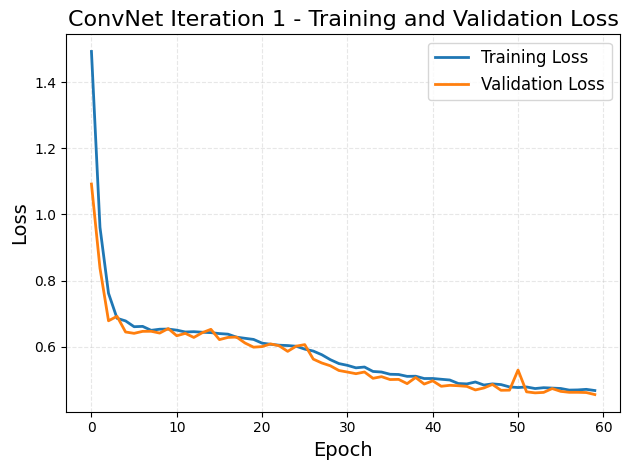

In [20]:
plt.figure()
plt.plot(train_losses, label="Training Loss", color="tab:blue", linewidth=2)
plt.plot(valid_losses,label="Validation Loss", color="tab:orange", linewidth=2)
plt.title("ConvNet Iteration 1 - Training and Validation Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [25]:
"""
Iteration 2:
- Larger kernel size: size 7, padding 3
- Channels per layer [32, 64, 128]
- Larger dense layer
"""
class ConvModel2(nn.Module):
    def __init__(self, in_channels=2, n_classes=6):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(in_channels, 32, kernel_size=7, padding=3),
            nn.ReLU(),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=7, padding=3),
            nn.ReLU(),
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=7, padding=3),
            nn.ReLU(),
        )

        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, n_classes)

    def forward(self, x):
        # CONVOLUTIONAL BLOCK
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        # DONWNSAMPLING BLOCK
        x = x.mean(dim=-1)

        # CLASSIFICATION BLOCK
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# Model parameters
n_classes   = 6
in_channels = 2

# Initialize model, loss function, optimizer
model = ConvModel2(in_channels=in_channels, n_classes=n_classes)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

model_path = "conv2_model.pth"
model.to(device)

n_params_conv = count_n_param(model)
print("Number of parameters in ConvModel:", n_params_conv)

def batch_accuracy(log_probs, targets):
    preds = log_probs.argmax(dim=-1)
    return (preds == targets).float().mean().item()

train_losses = []
valid_losses = []
train_accs   = []
valid_accs   = []
n_epochs = 80
for epoch in tqdm(range(n_epochs)):

    # Training loop
    model.train()
    running_loss_train = 0.0
    running_acc_train  = 0.0
    n_train_samples    = 0

    for batch_x, batch_y in dataloader_train:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()

        batch_y_predicted = model(batch_x)
        l = loss_fn(batch_y_predicted, batch_y)

        l.backward()
        optimizer.step()

        # logging
        batch_size = batch_x.size(0)
        running_loss_train += l.item() * batch_size
        running_acc_train  += batch_accuracy(batch_y_predicted, batch_y) * batch_size
        n_train_samples    += batch_size

    epoch_train_loss = running_loss_train / n_train_samples
    epoch_train_acc  = running_acc_train  / n_train_samples
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    # Validation loop
    model.eval()
    running_loss_valid = 0.0
    running_acc_valid  = 0.0
    n_valid_samples    = 0

    with torch.no_grad():
        for batch_x, batch_y in dataloader_valid:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            batch_y_predicted = model(batch_x)
            l = loss_fn(batch_y_predicted, batch_y)

            batch_size = batch_x.size(0)
            running_loss_valid += l.item() * batch_size
            running_acc_valid  += batch_accuracy(batch_y_predicted, batch_y) * batch_size
            n_valid_samples    += batch_size

    epoch_valid_loss = running_loss_valid / n_valid_samples
    epoch_valid_acc  = running_acc_valid  / n_valid_samples
    valid_losses.append(epoch_valid_loss)
    valid_accs.append(epoch_valid_acc)

    if epoch == 0 or (epoch + 1) % 5 == 0:
        print(
            f"Epoch {epoch}/{n_epochs} | "
            f"train_loss={epoch_train_loss:.4f}, valid_loss={epoch_valid_loss:.4f}, "
            f"train_acc={epoch_train_acc:.4f}, valid_acc={epoch_valid_acc:.4f}"
        )

# Save the model
torch.save(model.state_dict(), model_path)
print("Model saved to:", model_path)

Using device: cuda
Number of parameters in ConvModel: 80998


  1%|▏         | 1/80 [00:09<12:00,  9.12s/it]

Epoch 0/80 | train_loss=1.3672, valid_loss=1.0972, train_acc=0.3083, valid_acc=0.3948


  6%|▋         | 5/80 [00:45<11:27,  9.16s/it]

Epoch 4/80 | train_loss=0.6541, valid_loss=0.6509, train_acc=0.5952, valid_acc=0.5830


 12%|█▎        | 10/80 [01:32<10:58,  9.41s/it]

Epoch 9/80 | train_loss=0.5651, valid_loss=0.5308, train_acc=0.6750, valid_acc=0.6867


 19%|█▉        | 15/80 [02:19<10:04,  9.31s/it]

Epoch 14/80 | train_loss=0.5232, valid_loss=0.5064, train_acc=0.6913, valid_acc=0.7025


 25%|██▌       | 20/80 [03:05<09:18,  9.30s/it]

Epoch 19/80 | train_loss=0.5060, valid_loss=0.4953, train_acc=0.7015, valid_acc=0.7028


 31%|███▏      | 25/80 [03:52<08:29,  9.26s/it]

Epoch 24/80 | train_loss=0.5072, valid_loss=0.4887, train_acc=0.7015, valid_acc=0.7118


 38%|███▊      | 30/80 [04:38<07:41,  9.23s/it]

Epoch 29/80 | train_loss=0.4943, valid_loss=0.4863, train_acc=0.7075, valid_acc=0.7158


 44%|████▍     | 35/80 [05:24<06:58,  9.31s/it]

Epoch 34/80 | train_loss=0.4864, valid_loss=0.4958, train_acc=0.7132, valid_acc=0.7090


 50%|█████     | 40/80 [06:10<06:09,  9.24s/it]

Epoch 39/80 | train_loss=0.4699, valid_loss=0.4684, train_acc=0.7196, valid_acc=0.7202


 56%|█████▋    | 45/80 [06:57<05:23,  9.23s/it]

Epoch 44/80 | train_loss=0.4569, valid_loss=0.4492, train_acc=0.7234, valid_acc=0.7322


 62%|██████▎   | 50/80 [07:43<04:36,  9.20s/it]

Epoch 49/80 | train_loss=0.4496, valid_loss=0.4493, train_acc=0.7297, valid_acc=0.7210


 69%|██████▉   | 55/80 [08:28<03:49,  9.17s/it]

Epoch 54/80 | train_loss=0.4473, valid_loss=0.4390, train_acc=0.7318, valid_acc=0.7300


 75%|███████▌  | 60/80 [09:14<03:03,  9.15s/it]

Epoch 59/80 | train_loss=0.4481, valid_loss=0.4392, train_acc=0.7262, valid_acc=0.7330


 81%|████████▏ | 65/80 [10:00<02:17,  9.14s/it]

Epoch 64/80 | train_loss=0.4486, valid_loss=0.4309, train_acc=0.7275, valid_acc=0.7405


 88%|████████▊ | 70/80 [10:46<01:31,  9.14s/it]

Epoch 69/80 | train_loss=0.4457, valid_loss=0.4639, train_acc=0.7285, valid_acc=0.7212


 94%|█████████▍| 75/80 [11:31<00:45,  9.15s/it]

Epoch 74/80 | train_loss=0.4445, valid_loss=0.4289, train_acc=0.7318, valid_acc=0.7412


100%|██████████| 80/80 [12:17<00:00,  9.22s/it]

Epoch 79/80 | train_loss=0.4415, valid_loss=0.4344, train_acc=0.7378, valid_acc=0.7358
Model saved to: conv2_model.pth


In [23]:
print("Final validation accuracy:", valid_accs[-1])
print("Final validation loss:", valid_losses[-1])

Final validation accuracy: 0.7358333333333333
Final validation loss: 0.43443644388516744


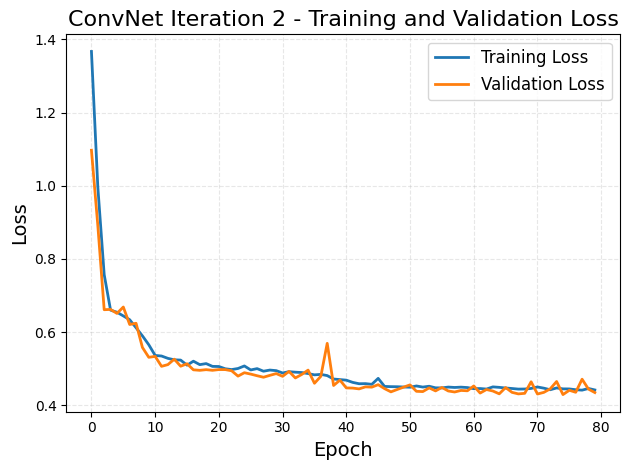

In [24]:
plt.figure()
plt.plot(train_losses, label="Training Loss", color="tab:blue", linewidth=2)
plt.plot(valid_losses,label="Validation Loss", color="tab:orange", linewidth=2)
plt.title("ConvNet Iteration 2 - Training and Validation Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()




<h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
We can see that increasing the receptive field from 22 samples to 50 and the model weights from 10k to 80k has small effect in the results obtained with the accuracy going from 70% to 73%. However since the training times are still in the order of minutes we will use this changes for the next iteration.


<hr style="border:10px solid blue"> </hr>
</font></h4>

In [27]:
"""
Iteration 3:
- Larger kernel size: size 7, padding 3
- Channels per layer [32, 64, 128]
- Larger dense layer
- Dropout 0.1
- Batch normalization
- Maxpool after each conv block
- Adding learning rate scheduler
"""
class Conv3Model(nn.Module):
    def __init__(self, in_channels=2, n_classes=6):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(in_channels, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        self.fc1 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(64, n_classes)

    def forward(self, x):
        # CONVOLUTIONAL BLOCK
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        # DONWNSAMPLING BLOCK
        x = x.mean(dim=-1)

        # CLASSIFICATION BLOCK
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# Model parameters
n_classes   = 6
in_channels = 2

# Initialize model, loss function, optimizer
model = Conv3Model(in_channels=in_channels, n_classes=n_classes)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)

model_path = "conv3_model.pth"
model.to(device)

n_params_conv = count_n_param(model)
print("Number of parameters in ConvModel:", n_params_conv)

def batch_accuracy(logits, targets):
    preds = logits.argmax(dim=-1)
    return (preds == targets).float().mean().item()

train_losses = []
valid_losses = []
train_accs   = []
valid_accs   = []

best_valid_loss = float('inf')
best_epoch = -1

n_epochs = 80
for epoch in tqdm(range(n_epochs)):

    # TRAINING
    model.train()
    running_loss_train = 0.0
    running_acc_train  = 0.0
    n_train_samples    = 0

    for batch_x, batch_y in dataloader_train:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()

        batch_y_predicted = model(batch_x)
        l = loss_fn(batch_y_predicted, batch_y)

        l.backward()
        optimizer.step()

        batch_size = batch_x.size(0)
        running_loss_train += l.item() * batch_size
        running_acc_train  += batch_accuracy(batch_y_predicted, batch_y) * batch_size
        n_train_samples    += batch_size

    epoch_train_loss = running_loss_train / n_train_samples
    epoch_train_acc  = running_acc_train  / n_train_samples
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    #  VALIDATION
    model.eval()
    running_loss_valid = 0.0
    running_acc_valid  = 0.0
    n_valid_samples    = 0

    with torch.no_grad():
        for batch_x, batch_y in dataloader_valid:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            batch_y_predicted = model(batch_x)
            l = loss_fn(batch_y_predicted, batch_y)

            batch_size = batch_x.size(0)
            running_loss_valid += l.item() * batch_size
            running_acc_valid  += batch_accuracy(batch_y_predicted, batch_y) * batch_size
            n_valid_samples    += batch_size

    epoch_valid_loss = running_loss_valid / n_valid_samples
    epoch_valid_acc  = running_acc_valid  / n_valid_samples
    valid_losses.append(epoch_valid_loss)
    valid_accs.append(epoch_valid_acc)

    scheduler.step(epoch_valid_loss)

    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        best_epoch = epoch
        torch.save(model.state_dict(), model_path)

    if epoch == 0 or (epoch + 1) % 5 == 0:
        print(
            f"Epoch {epoch}/{n_epochs} | "
            f"train_loss={epoch_train_loss:.4f}, valid_loss={epoch_valid_loss:.4f}, "
            f"train_acc={epoch_train_acc:.4f}, valid_acc={epoch_valid_acc:.4f}"
        )

print(f"Best model was at epoch {best_epoch} "
      f"with valid_loss={best_valid_loss:.4f}")


Using device: cuda
Number of parameters in ConvModel: 81446


  1%|▏         | 1/80 [00:05<06:55,  5.26s/it]

Epoch 0/80 | train_loss=1.0616, valid_loss=0.8602, train_acc=0.4440, valid_acc=0.5632


  6%|▋         | 5/80 [00:25<06:23,  5.11s/it]

Epoch 4/80 | train_loss=0.5218, valid_loss=1.9067, train_acc=0.6906, valid_acc=0.4058


 12%|█▎        | 10/80 [00:50<05:55,  5.08s/it]

Epoch 9/80 | train_loss=0.4650, valid_loss=4.5945, train_acc=0.7209, valid_acc=0.3412


 19%|█▉        | 15/80 [01:16<05:29,  5.07s/it]

Epoch 14/80 | train_loss=0.4419, valid_loss=1.8049, train_acc=0.7282, valid_acc=0.5477


 25%|██▌       | 20/80 [01:41<05:04,  5.07s/it]

Epoch 19/80 | train_loss=0.4329, valid_loss=0.4444, train_acc=0.7367, valid_acc=0.7412


 31%|███▏      | 25/80 [02:06<04:38,  5.06s/it]

Epoch 24/80 | train_loss=0.4152, valid_loss=0.5020, train_acc=0.7458, valid_acc=0.7298


 38%|███▊      | 30/80 [02:32<04:12,  5.05s/it]

Epoch 29/80 | train_loss=0.3997, valid_loss=0.6095, train_acc=0.7592, valid_acc=0.6990


 44%|████▍     | 35/80 [02:57<03:47,  5.05s/it]

Epoch 34/80 | train_loss=0.3934, valid_loss=4.5923, train_acc=0.7652, valid_acc=0.5007


 50%|█████     | 40/80 [03:22<03:22,  5.06s/it]

Epoch 39/80 | train_loss=0.3526, valid_loss=0.6201, train_acc=0.8034, valid_acc=0.7225


 56%|█████▋    | 45/80 [03:48<02:57,  5.06s/it]

Epoch 44/80 | train_loss=0.3035, valid_loss=0.4104, train_acc=0.8416, valid_acc=0.8168


 62%|██████▎   | 50/80 [04:13<02:31,  5.06s/it]

Epoch 49/80 | train_loss=0.2450, valid_loss=0.4413, train_acc=0.8755, valid_acc=0.8282


 69%|██████▉   | 55/80 [04:38<02:06,  5.05s/it]

Epoch 54/80 | train_loss=0.2185, valid_loss=1.1192, train_acc=0.8855, valid_acc=0.7800


 75%|███████▌  | 60/80 [05:03<01:41,  5.06s/it]

Epoch 59/80 | train_loss=0.1942, valid_loss=0.6643, train_acc=0.8971, valid_acc=0.8218


 81%|████████▏ | 65/80 [05:29<01:15,  5.06s/it]

Epoch 64/80 | train_loss=0.1818, valid_loss=0.4087, train_acc=0.9028, valid_acc=0.8415


 88%|████████▊ | 70/80 [05:54<00:50,  5.05s/it]

Epoch 69/80 | train_loss=0.1541, valid_loss=0.6987, train_acc=0.9155, valid_acc=0.8338


 94%|█████████▍| 75/80 [06:19<00:25,  5.04s/it]

Epoch 74/80 | train_loss=0.1445, valid_loss=1.3880, train_acc=0.9188, valid_acc=0.8193


100%|██████████| 80/80 [06:44<00:00,  5.06s/it]

Epoch 79/80 | train_loss=0.1350, valid_loss=0.5901, train_acc=0.9267, valid_acc=0.8398
Best model was at epoch 56 with valid_loss=0.3741


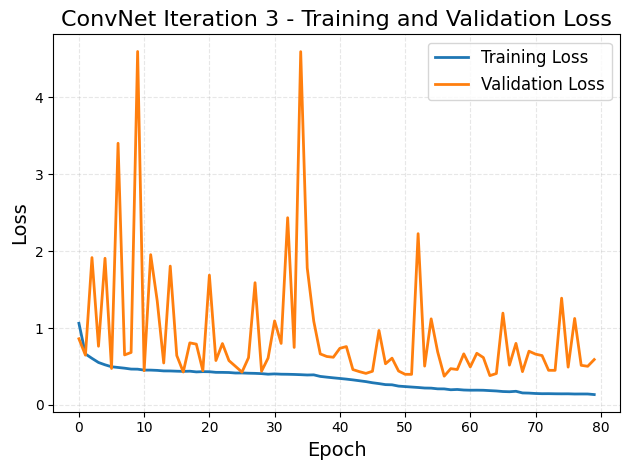

In [27]:
plt.figure()
plt.plot(train_losses, label="Training Loss", color="tab:blue", linewidth=2)
plt.plot(valid_losses,label="Validation Loss", color="tab:orange", linewidth=2)
plt.title("ConvNet Iteration 3 - Training and Validation Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()





<h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>

We see that using more advances techinques such as dropout, maxpool after each convolutional layer, and reducing the learning rate during training has pushed the accuracy up to 83%. We can also see that the training is less stable, in the sence that the validation loss is changing between different epochs more than before, this is most probably due to the size of the model. Now it's easier for the model to learn and be too confident at some points.

<hr style="border:10px solid blue"> </hr>
</font></h4>


<h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Next, we will use the same convolution block as in the previous architecture for the initial feature extraction. However, one problem of conv layers is that they have a limited receptive field (max 50 in our conv block). Each means they will struggle to capture long-range temporal structures, dependencies over 100s of samples. For that reason we will introduce a recurrent network so that the model has memory over longer time intervals, this also includes some ordering, which is natural in time series. As explained durng the lecture we will use the Gated recurrent Unit (GRU), a simplication of LSTM that limits the number of parameters to allow for faster training and minimize the risk of overfitting.

<hr style="border:10px solid blue"> </hr>
</font></h4>

In [19]:
"""
Iteration 4:
- Larger kernel size: size 7, padding 3
- Channels per layer [32, 64, 128]
- Larger dense layer
- Dropout 0.1
- Batch normalization
- Learning rate scheduler
- Maxpool after each conv block
- GRU
"""
class Conv3GRUModel(nn.Module):
    def __init__(self, in_channels=2, n_classes=6, hidden_rnn=64):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(in_channels, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        self.gru = nn.GRU(
            input_size=128,
            hidden_size=hidden_rnn,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.fc1 = nn.Linear(2 * hidden_rnn, 64)
        self.dropout = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(64, n_classes)

    def forward(self, x):
        # CONVOLUTIONAL BLOCK
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        # RECURRENT BLOCK
        x = x.permute(0, 2, 1)
        h_out, _ = self.gru(x)
        last = h_out[:, -1, :]

        # CLASSIFICATION BLOCK
        x = F.relu(self.fc1(last))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# Model parameters
n_classes   = 6
in_channels = 2

# Initialize model, loss function, optimizer
model = Conv3GRUModel(in_channels=in_channels, n_classes=n_classes)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)

model_path = "conv3_gru_model.pth"
model.to(device)

n_params_conv = count_n_param(model)
print("Number of parameters in ConvModel:", n_params_conv)

def batch_accuracy(logits, targets):
    preds = logits.argmax(dim=-1)
    return (preds == targets).float().mean().item()

train_losses = []
valid_losses = []
train_accs   = []
valid_accs   = []

best_valid_loss = float('inf')
best_epoch = -1

n_epochs = 80
for epoch in tqdm(range(n_epochs)):

    # TRAINING
    model.train()
    running_loss_train = 0.0
    running_acc_train  = 0.0
    n_train_samples    = 0

    for batch_x, batch_y in dataloader_train:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()

        batch_y_predicted = model(batch_x)
        l = loss_fn(batch_y_predicted, batch_y)

        l.backward()
        optimizer.step()

        batch_size = batch_x.size(0)
        running_loss_train += l.item() * batch_size
        running_acc_train  += batch_accuracy(batch_y_predicted, batch_y) * batch_size
        n_train_samples    += batch_size

    epoch_train_loss = running_loss_train / n_train_samples
    epoch_train_acc  = running_acc_train  / n_train_samples
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    #  VALIDATION
    model.eval()
    running_loss_valid = 0.0
    running_acc_valid  = 0.0
    n_valid_samples    = 0

    with torch.no_grad():
        for batch_x, batch_y in dataloader_valid:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            batch_y_predicted = model(batch_x)
            l = loss_fn(batch_y_predicted, batch_y)

            batch_size = batch_x.size(0)
            running_loss_valid += l.item() * batch_size
            running_acc_valid  += batch_accuracy(batch_y_predicted, batch_y) * batch_size
            n_valid_samples    += batch_size

    epoch_valid_loss = running_loss_valid / n_valid_samples
    epoch_valid_acc  = running_acc_valid  / n_valid_samples
    valid_losses.append(epoch_valid_loss)
    valid_accs.append(epoch_valid_acc)

    scheduler.step(epoch_valid_loss)

    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        best_epoch = epoch
        torch.save(model.state_dict(), model_path)
        print(f"New best model at epoch {epoch} | valid_loss={epoch_valid_loss:.4f}")

    if epoch == 0 or (epoch + 1) % 5 == 0:
        print(
            f"Epoch {epoch}/{n_epochs} | "
            f"train_loss={epoch_train_loss:.4f}, valid_loss={epoch_valid_loss:.4f}, "
            f"train_acc={epoch_train_acc:.4f}, valid_acc={epoch_valid_acc:.4f}"
        )

print(f"Best model was at epoch {best_epoch} "
      f"with valid_loss={best_valid_loss:.4f}")

Using device: cuda
Number of parameters in ConvModel: 155942


  1%|▏         | 1/80 [00:06<09:07,  6.93s/it]

New best model at epoch 0 | valid_loss=1.1590
Epoch 0/80 | train_loss=1.2277, valid_loss=1.1590, train_acc=0.3421, valid_acc=0.4063


  2%|▎         | 2/80 [00:13<08:48,  6.78s/it]

New best model at epoch 1 | valid_loss=0.6620


  4%|▍         | 3/80 [00:20<08:40,  6.76s/it]

New best model at epoch 2 | valid_loss=0.6314


  5%|▌         | 4/80 [00:27<08:33,  6.75s/it]

New best model at epoch 3 | valid_loss=0.6312


  6%|▋         | 5/80 [00:33<08:25,  6.74s/it]

New best model at epoch 4 | valid_loss=0.6232
Epoch 4/80 | train_loss=0.6420, valid_loss=0.6232, train_acc=0.5888, valid_acc=0.5967


 10%|█         | 8/80 [00:53<08:04,  6.73s/it]

New best model at epoch 7 | valid_loss=0.6221


 12%|█▎        | 10/80 [01:07<07:50,  6.73s/it]

Epoch 9/80 | train_loss=0.6732, valid_loss=0.6523, train_acc=0.5820, valid_acc=0.5775


 14%|█▍        | 11/80 [01:14<07:44,  6.73s/it]

New best model at epoch 10 | valid_loss=0.6195


 19%|█▉        | 15/80 [01:41<07:18,  6.74s/it]

Epoch 14/80 | train_loss=0.6327, valid_loss=0.6427, train_acc=0.5990, valid_acc=0.5860


 21%|██▏       | 17/80 [01:54<07:04,  6.74s/it]

New best model at epoch 16 | valid_loss=0.6066


 22%|██▎       | 18/80 [02:01<06:57,  6.73s/it]

New best model at epoch 17 | valid_loss=0.5347


 25%|██▌       | 20/80 [02:14<06:44,  6.74s/it]

New best model at epoch 19 | valid_loss=0.4977
Epoch 19/80 | train_loss=0.5215, valid_loss=0.4977, train_acc=0.6903, valid_acc=0.6940


 26%|██▋       | 21/80 [02:21<06:37,  6.73s/it]

New best model at epoch 20 | valid_loss=0.4796


 29%|██▉       | 23/80 [02:34<06:23,  6.72s/it]

New best model at epoch 22 | valid_loss=0.4716


 31%|███▏      | 25/80 [02:48<06:09,  6.71s/it]

New best model at epoch 24 | valid_loss=0.4698
Epoch 24/80 | train_loss=0.4633, valid_loss=0.4698, train_acc=0.7249, valid_acc=0.7082


 35%|███▌      | 28/80 [03:08<05:48,  6.71s/it]

New best model at epoch 27 | valid_loss=0.4691


 38%|███▊      | 30/80 [03:21<05:35,  6.71s/it]

Epoch 29/80 | train_loss=0.4498, valid_loss=0.5177, train_acc=0.7429, valid_acc=0.7185


 44%|████▍     | 35/80 [03:55<05:01,  6.70s/it]

Epoch 34/80 | train_loss=0.3686, valid_loss=0.5058, train_acc=0.7941, valid_acc=0.7462


 48%|████▊     | 38/80 [04:15<04:42,  6.72s/it]

New best model at epoch 37 | valid_loss=0.4323


 50%|█████     | 40/80 [04:29<04:28,  6.71s/it]

Epoch 39/80 | train_loss=0.3915, valid_loss=0.4833, train_acc=0.8125, valid_acc=0.7680


 56%|█████▋    | 45/80 [05:02<03:55,  6.72s/it]

Epoch 44/80 | train_loss=0.1488, valid_loss=0.6221, train_acc=0.9259, valid_acc=0.8098


 62%|██████▎   | 50/80 [05:36<03:20,  6.69s/it]

Epoch 49/80 | train_loss=0.0979, valid_loss=0.6344, train_acc=0.9571, valid_acc=0.8307


 69%|██████▉   | 55/80 [06:09<02:47,  6.71s/it]

Epoch 54/80 | train_loss=0.0643, valid_loss=0.8250, train_acc=0.9764, valid_acc=0.8260


 75%|███████▌  | 60/80 [06:43<02:14,  6.70s/it]

Epoch 59/80 | train_loss=0.0431, valid_loss=1.0228, train_acc=0.9849, valid_acc=0.8277


 81%|████████▏ | 65/80 [07:16<01:40,  6.71s/it]

Epoch 64/80 | train_loss=0.0114, valid_loss=1.2287, train_acc=0.9968, valid_acc=0.8288


 88%|████████▊ | 70/80 [07:50<01:07,  6.71s/it]

Epoch 69/80 | train_loss=0.0127, valid_loss=1.3504, train_acc=0.9968, valid_acc=0.8197


 94%|█████████▍| 75/80 [08:23<00:33,  6.69s/it]

Epoch 74/80 | train_loss=0.0036, valid_loss=1.4233, train_acc=0.9996, valid_acc=0.8282


100%|██████████| 80/80 [08:57<00:00,  6.71s/it]

Epoch 79/80 | train_loss=0.0036, valid_loss=1.4385, train_acc=0.9993, valid_acc=0.8293
Best model was at epoch 37 with valid_loss=0.4323


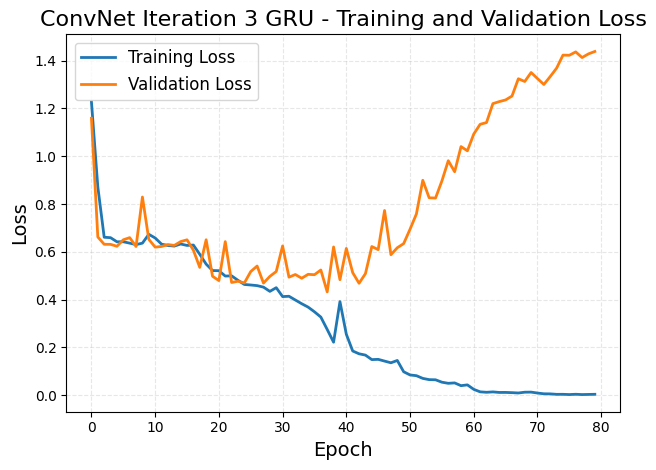

In [30]:
plt.figure()
plt.plot(train_losses, label="Training Loss", color="tab:blue", linewidth=2)
plt.plot(valid_losses,label="Validation Loss", color="tab:orange", linewidth=2)
plt.title("ConvNet Iteration 3 GRU - Training and Validation Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()




<h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>

We can see that there is a large amount of overfitting. For larger networks (we went from 10k-weight network to 155k) it makes sense to use data augmentation to prevent overfitting. We will use the following transformations to simulate possible realistic variabilities:
- Time misalignment: To simulate imperfect synchronization
- Amplitude variations: To simulate gain variations from the channel
- Noise: Additive Gaussian noise


<hr style="border:10px solid blue"> </hr>
</font></h4>

In [31]:
def augment_signal(x, max_shift=20, noise_std=0.01, gain_range=(0.8, 1.2)):
    # time shift
    shift = random.randint(-max_shift, max_shift)
    x = torch.roll(x, shifts=shift, dims=-1)
    # random gain
    gain = random.uniform(*gain_range)
    x = x * gain
    # gaussian noise
    noise = torch.randn_like(x) * noise_std
    x = x + noise

    return x

def collate_fn_augment(batch):
    xs, ys = zip(*batch)

    xs_aug = [augment_signal(x.clone()) for x in xs]
    X = torch.stack(xs_aug, dim=0)
    y = torch.tensor(ys, dtype=torch.long)

    return X, y

In [32]:
# Apply data augmentation only ONLY on training set
dataloader_train = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    collate_fn=collate_fn_augment
)

dataloader_valid = DataLoader(
    valid_dataset,
    batch_size=64,
    shuffle=False,
    collate_fn=None
)

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# Model parameters
n_classes   = 6
in_channels = 2

# Initialize model, loss function, optimizer
model = Conv3GRUModel(in_channels=in_channels, n_classes=n_classes)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)

model_path = "conv3_gru_aug_model.pth"
model.to(device)

n_params_conv = count_n_param(model)
print("Number of parameters in ConvModel:", n_params_conv)

def batch_accuracy(logits, targets):
    preds = logits.argmax(dim=-1)
    return (preds == targets).float().mean().item()

train_losses = []
valid_losses = []
train_accs   = []
valid_accs   = []

best_valid_loss = float('inf')
best_epoch = -1

n_epochs = 80
for epoch in tqdm(range(n_epochs)):

    # TRAINING
    model.train()
    running_loss_train = 0.0
    running_acc_train  = 0.0
    n_train_samples    = 0

    for batch_x, batch_y in dataloader_train:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()

        batch_y_predicted = model(batch_x)
        l = loss_fn(batch_y_predicted, batch_y)

        l.backward()
        optimizer.step()

        batch_size = batch_x.size(0)
        running_loss_train += l.item() * batch_size
        running_acc_train  += batch_accuracy(batch_y_predicted, batch_y) * batch_size
        n_train_samples    += batch_size

    epoch_train_loss = running_loss_train / n_train_samples
    epoch_train_acc  = running_acc_train  / n_train_samples
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    #  VALIDATION
    model.eval()
    running_loss_valid = 0.0
    running_acc_valid  = 0.0
    n_valid_samples    = 0

    with torch.no_grad():
        for batch_x, batch_y in dataloader_valid:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            batch_y_predicted = model(batch_x)
            l = loss_fn(batch_y_predicted, batch_y)

            batch_size = batch_x.size(0)
            running_loss_valid += l.item() * batch_size
            running_acc_valid  += batch_accuracy(batch_y_predicted, batch_y) * batch_size
            n_valid_samples    += batch_size

    epoch_valid_loss = running_loss_valid / n_valid_samples
    epoch_valid_acc  = running_acc_valid  / n_valid_samples
    valid_losses.append(epoch_valid_loss)
    valid_accs.append(epoch_valid_acc)

    scheduler.step(epoch_valid_loss)

    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        best_epoch = epoch
        torch.save(model.state_dict(), model_path)
        print(f"New best model at epoch {epoch} | valid_loss={epoch_valid_loss:.4f}")

    if epoch == 0 or (epoch + 1) % 5 == 0:
        print(
            f"Epoch {epoch}/{n_epochs} | "
            f"train_loss={epoch_train_loss:.4f}, valid_loss={epoch_valid_loss:.4f}, "
            f"train_acc={epoch_train_acc:.4f}, valid_acc={epoch_valid_acc:.4f}"
        )

print(f"Best model was at epoch {best_epoch} "
      f"with valid_loss={best_valid_loss:.4f}")

Using device: cuda
Number of parameters in ConvModel: 155942


  1%|▏         | 1/80 [00:08<10:43,  8.15s/it]

New best model at epoch 0 | valid_loss=1.0687
Epoch 0/80 | train_loss=1.3278, valid_loss=1.0687, train_acc=0.3087, valid_acc=0.4027


  2%|▎         | 2/80 [00:16<10:27,  8.05s/it]

New best model at epoch 1 | valid_loss=0.6662


  6%|▋         | 5/80 [00:40<10:04,  8.07s/it]

New best model at epoch 4 | valid_loss=0.6325
Epoch 4/80 | train_loss=0.6489, valid_loss=0.6325, train_acc=0.5868, valid_acc=0.5878


  9%|▉         | 7/80 [00:56<09:52,  8.12s/it]

New best model at epoch 6 | valid_loss=0.6260


 12%|█▎        | 10/80 [01:20<09:28,  8.12s/it]

New best model at epoch 9 | valid_loss=0.6243
Epoch 9/80 | train_loss=0.6449, valid_loss=0.6243, train_acc=0.5895, valid_acc=0.5960


 19%|█▉        | 15/80 [02:01<08:45,  8.08s/it]

Epoch 14/80 | train_loss=0.6304, valid_loss=0.6689, train_acc=0.5922, valid_acc=0.5753


 21%|██▏       | 17/80 [02:17<08:30,  8.11s/it]

New best model at epoch 16 | valid_loss=0.6151


 25%|██▌       | 20/80 [02:41<08:06,  8.10s/it]

Epoch 19/80 | train_loss=0.6281, valid_loss=0.6273, train_acc=0.5991, valid_acc=0.5903


 31%|███▏      | 25/80 [03:22<07:24,  8.08s/it]

New best model at epoch 24 | valid_loss=0.6049
Epoch 24/80 | train_loss=0.6258, valid_loss=0.6049, train_acc=0.6100, valid_acc=0.6278


 34%|███▍      | 27/80 [03:38<07:07,  8.06s/it]

New best model at epoch 26 | valid_loss=0.5234


 36%|███▋      | 29/80 [03:54<06:53,  8.10s/it]

New best model at epoch 28 | valid_loss=0.4852


 38%|███▊      | 30/80 [04:02<06:43,  8.07s/it]

Epoch 29/80 | train_loss=0.5097, valid_loss=0.5050, train_acc=0.7015, valid_acc=0.6938


 39%|███▉      | 31/80 [04:10<06:37,  8.10s/it]

New best model at epoch 30 | valid_loss=0.4639


 44%|████▍     | 35/80 [04:43<06:05,  8.13s/it]

Epoch 34/80 | train_loss=0.4423, valid_loss=0.6059, train_acc=0.7572, valid_acc=0.7168


 45%|████▌     | 36/80 [04:51<05:56,  8.09s/it]

New best model at epoch 35 | valid_loss=0.4101


 46%|████▋     | 37/80 [04:59<05:50,  8.14s/it]

New best model at epoch 36 | valid_loss=0.4064


 48%|████▊     | 38/80 [05:07<05:43,  8.18s/it]

New best model at epoch 37 | valid_loss=0.3644


 49%|████▉     | 39/80 [05:15<05:33,  8.13s/it]

New best model at epoch 38 | valid_loss=0.2941


 50%|█████     | 40/80 [05:23<05:25,  8.14s/it]

Epoch 39/80 | train_loss=0.2917, valid_loss=0.3552, train_acc=0.8475, valid_acc=0.8188


 55%|█████▌    | 44/80 [05:56<04:52,  8.12s/it]

New best model at epoch 43 | valid_loss=0.2939


 56%|█████▋    | 45/80 [06:04<04:42,  8.07s/it]

Epoch 44/80 | train_loss=0.2805, valid_loss=0.4559, train_acc=0.8518, valid_acc=0.7945


 57%|█████▊    | 46/80 [06:12<04:35,  8.11s/it]

New best model at epoch 45 | valid_loss=0.2923


 62%|██████▎   | 50/80 [06:45<04:04,  8.16s/it]

New best model at epoch 49 | valid_loss=0.2878
Epoch 49/80 | train_loss=0.2716, valid_loss=0.2878, train_acc=0.8552, valid_acc=0.8392


 64%|██████▍   | 51/80 [06:53<03:54,  8.09s/it]

New best model at epoch 50 | valid_loss=0.2863


 66%|██████▋   | 53/80 [07:09<03:39,  8.12s/it]

New best model at epoch 52 | valid_loss=0.2849


 69%|██████▉   | 55/80 [07:25<03:22,  8.12s/it]

Epoch 54/80 | train_loss=0.2676, valid_loss=0.3853, train_acc=0.8585, valid_acc=0.8222


 70%|███████   | 56/80 [07:33<03:15,  8.13s/it]

New best model at epoch 55 | valid_loss=0.2826


 72%|███████▎  | 58/80 [07:49<02:57,  8.09s/it]

New best model at epoch 57 | valid_loss=0.2775


 75%|███████▌  | 60/80 [08:05<02:41,  8.06s/it]

Epoch 59/80 | train_loss=0.2597, valid_loss=0.3274, train_acc=0.8637, valid_acc=0.8345


 81%|████████▏ | 65/80 [08:46<02:01,  8.10s/it]

Epoch 64/80 | train_loss=0.2522, valid_loss=0.3553, train_acc=0.8652, valid_acc=0.8308


 88%|████████▊ | 70/80 [09:26<01:20,  8.06s/it]

Epoch 69/80 | train_loss=0.2309, valid_loss=0.3029, train_acc=0.8779, valid_acc=0.8508


 94%|█████████▍| 75/80 [10:06<00:40,  8.03s/it]

Epoch 74/80 | train_loss=0.2174, valid_loss=0.3223, train_acc=0.8807, valid_acc=0.8427


100%|██████████| 80/80 [10:47<00:00,  8.09s/it]

Epoch 79/80 | train_loss=0.2101, valid_loss=0.3884, train_acc=0.8870, valid_acc=0.8355
Best model was at epoch 57 with valid_loss=0.2775


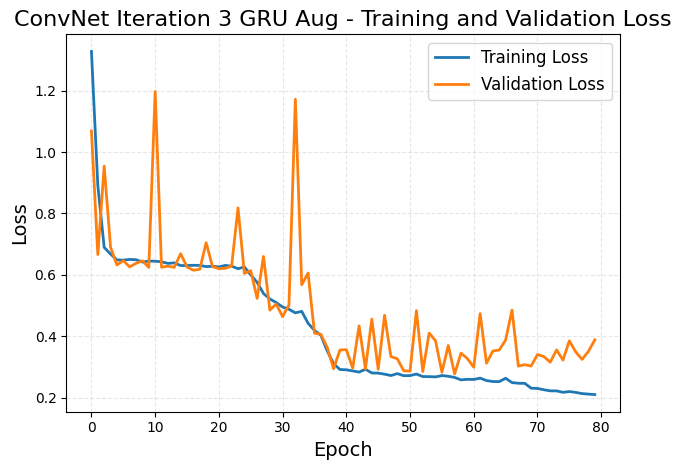

In [34]:
plt.figure()
plt.plot(train_losses, label="Training Loss", color="tab:blue", linewidth=2)
plt.plot(valid_losses,label="Validation Loss", color="tab:orange", linewidth=2)
plt.title("ConvNet Iteration 3 GRU Aug - Training and Validation Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## Synthèse de résultats
Une fois que votre ou vos réseaux sont entrainez vous comparez leurs performances selon les métriques définies en introduction sur l'ensemble de test sans oublier de mesurer également la complexité de chaque approche en termes de nombre de paramètres. Si vous avez testé des approches qui vous semblent avoir échoué vous pouvez rédiger un petit paragraphe pour expliquer votre analyse de cet échec.

### 3.1 Accuracy
We load the selected model **X** due to its better performance on the val set and plot some performance metrics.

In [33]:
test_h5_path = "test.hdf5"
model_path = "./models/conv3_gru_aug_model.pth"
test_model = Conv3GRUModel(in_channels=2, n_classes=6)

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
test_dataset = MyDataset(test_h5_path)
batch_size = 8

with h5py.File(test_h5_path , 'r') as data:
    test_signals = np.array(data['signaux'])      # shape: (N, 2, 2048)
    test_snr = np.array(data['snr'])              # shape: (N,)
    labels_dict = get_labels(data)           # {label_id: label_name, ...}
    test_labels_id = np.array(data['labels'])     # shape: (N,)
    test_labels = [labels_dict[id] for id in test_labels_id] # shape: (N,)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

models = {
    "Conv2":  {"model": ConvModel2(in_channels=2, n_classes=6),   "path": "./models/conv2_model.pth"},
    "Conv3":  {"model": Conv3Model(in_channels=2, n_classes=6),   "path": "./models/conv3_model.pth"},
    "Conv3GRU":{"model": Conv3GRUModel(in_channels=2, n_classes=6),"path": "./models/conv3_gru_model.pth"},
    "Conv3GRUAug":{"model": Conv3GRUModel(in_channels=2, n_classes=6), "path": "./models/conv3_gru_aug_model.pth"},
}

for name, info in models.items():
    test_model = info["model"]
    model_path = info["path"]

    try:
        state = torch.load(model_path, map_location=device)
        if isinstance(state, dict):
            # typical state_dict -> load weights
            test_model.load_state_dict(state)
        else:
            # file contained a full saved module
            test_model = state
    except FileNotFoundError:
        print(f"Warning: checkpoint {model_path} not found. Using randomly initialized {name}.")
    except Exception as e:
        print(f"Warning loading {model_path}: {e}. Proceeding with current instance of {name}.")

    test_model.to(device)
    test_model.eval()

    all_preds = []
    all_targets = []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            out = test_model(xb)  # logits
            preds = out.argmax(dim=-1)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(yb.cpu().numpy())

    y_pred = np.concatenate(all_preds, axis=0)
    y_true = np.concatenate(all_targets, axis=0)

    global_acc = accuracy_score(y_true, y_pred)
    print(f"Model {name} | Device: {device} | Test samples: {len(test_dataset)} | Overall accuracy: {global_acc:.4f}")

Model Conv2 | Device: mps | Test samples: 10000 | Overall accuracy: 0.7369
Model Conv3 | Device: mps | Test samples: 10000 | Overall accuracy: 0.8551
Model Conv3GRU | Device: mps | Test samples: 10000 | Overall accuracy: 0.8295
Model Conv3GRUAug | Device: mps | Test samples: 10000 | Overall accuracy: 0.8591


<h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>

The global accuracy obtained is **85%** with the Conv3 model and the Conv3GRUAug model. Since they are very close, we'll run the SNR vs. Accuracy experiment on both.

<hr style="border:10px solid blue"> </hr>
</font></h4>

In [36]:
# NB: We just duplicate the code to get the y_true_conv3 and y_pred_conv3 for the Conv3 model only

models = {
    "Conv3":  {"model": Conv3Model(in_channels=2, n_classes=6),   "path": "./models/conv3_model.pth"},
}

for name, info in models.items():
    test_model = info["model"]
    model_path = info["path"]

    try:
        state = torch.load(model_path, map_location=device)
        if isinstance(state, dict):
            # typical state_dict -> load weights
            test_model.load_state_dict(state)
        else:
            # file contained a full saved module
            test_model = state
    except FileNotFoundError:
        print(f"Warning: checkpoint {model_path} not found. Using randomly initialized {name}.")
    except Exception as e:
        print(f"Warning loading {model_path}: {e}. Proceeding with current instance of {name}.")

    test_model.to(device)
    test_model.eval()

    all_preds = []
    all_targets = []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            out = test_model(xb)  # logits
            preds = out.argmax(dim=-1)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(yb.cpu().numpy())

    y_pred_conv3 = np.concatenate(all_preds, axis=0)
    y_true_conv3 = np.concatenate(all_targets, axis=0)

    global_acc = accuracy_score(y_true_conv3, y_pred_conv3)
    print(f"Model {name} | Device: {device} | Test samples: {len(test_dataset)} | Overall accuracy: {global_acc:.4f}")

Model Conv3 | Device: mps | Test samples: 10000 | Overall accuracy: 0.8551


### 3.2 Accuracy vs. SNR

In [49]:
def snr_accuracy_summary(y_pair, snr, labels_dict=None, n_classes=None, plot=True, return_cms=True, title=None):
    """
    Compute per‑SNR accuracy and confusion matrices from (y_true, y_pred).
    Args:
      y_pair: tuple (y_true, y_pred) — 1D numpy arrays or lists
      snr: 1D array-like of same length as y_true giving SNR per sample
      labels_dict: optional dict {id: name} used for confusion plots
      n_classes: optional int, number of classes (inferred if None)
      plot: if True, draw the SNR vs accuracy bar plot
      return_cms: if True, return list of confusion matrices
      title: optional str, title for the plot (defaults to sensible label)

    Returns:
      snr_results (dict), cms (list) or None, overall_acc (float)
    """
    y_true, y_pred = y_pair
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    snr = np.asarray(snr)

    if y_true.shape[0] != snr.shape[0] or y_pred.shape[0] != snr.shape[0]:
        raise ValueError("y_true, y_pred and snr must have the same length")

    if n_classes is None:
        if labels_dict is not None:
            n_classes = len(labels_dict)
        else:
            n_classes = int(max(y_true.max(), y_pred.max()) + 1)

    snr_levels = np.unique(snr)
    snr_results = {}
    cms = []
    for level in snr_levels:
        idx = np.where(snr == level)[0]
        y_t = y_true[idx]
        y_p = y_pred[idx]
        cm = confusion_matrix(y_t, y_p, labels=np.arange(n_classes))
        acc = accuracy_score(y_t, y_p) if len(idx) > 0 else float('nan')
        snr_results[int(level)] = {
            "indices": idx,
            "y_true": y_t,
            "y_pred": y_p,
            "confusion_matrix": cm,
            "accuracy": acc,
            "n_samples": len(idx),
        }
        cms.append(cm)
        print(f"SNR={int(level)} dB | samples={len(idx)} | acc={acc:.3f}")

    overall_acc = accuracy_score(y_true, y_pred)

    if plot:
        ordered_levels = np.array(sorted(snr_results.keys()))
        ordered_acc = [snr_results[int(l)]["accuracy"] for l in ordered_levels]
        correct = [100.0 * a for a in ordered_acc]
        error = [100.0 - c for c in correct]

        x = np.arange(len(ordered_levels))
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.bar(x, correct, color='chartreuse', label='Correct (%)')
        ax.bar(x, error, bottom=correct, color='coral', label='Error (%)')

        overall_acc_pct = 100.0 * overall_acc
        ax.axhline(overall_acc_pct, color='blue', linestyle='--', linewidth=2,
                   label=f'Overall accuracy = {overall_acc_pct:.1f}%')

        ax.set_xticks(x)
        ax.set_xticklabels([int(l) for l in ordered_levels])
        ax.set_ylim(0, 100)
        ax.set_xlabel("SNR (dB)")
        ax.set_ylabel("Percentage (%)")
        plot_title = title if title is not None else "Accuracy (correct) vs Error per SNR"
        ax.set_title(plot_title)
        ax.legend()
        plt.tight_layout()
        plt.show()
    
    return (snr_results, cms, overall_acc) if return_cms else (snr_results, None, overall_acc)

SNR=0 dB | samples=2420 | acc=0.451
SNR=10 dB | samples=2600 | acc=0.956
SNR=20 dB | samples=2320 | acc=0.999
SNR=30 dB | samples=2660 | acc=0.999


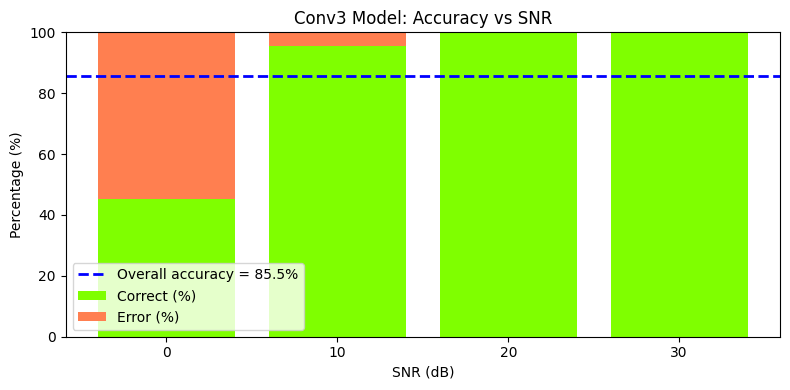

In [50]:
# Conv3 model
snrs_results, cms, overall_acc = snr_accuracy_summary((y_true_conv3, y_pred_conv3), test_snr, labels_dict=labels_dict, n_classes=6, plot=True, return_cms=True, title="Conv3 Model: Accuracy vs SNR")  

SNR=0 dB | samples=2420 | acc=0.435
SNR=10 dB | samples=2600 | acc=0.984
SNR=20 dB | samples=2320 | acc=1.000
SNR=30 dB | samples=2660 | acc=1.000


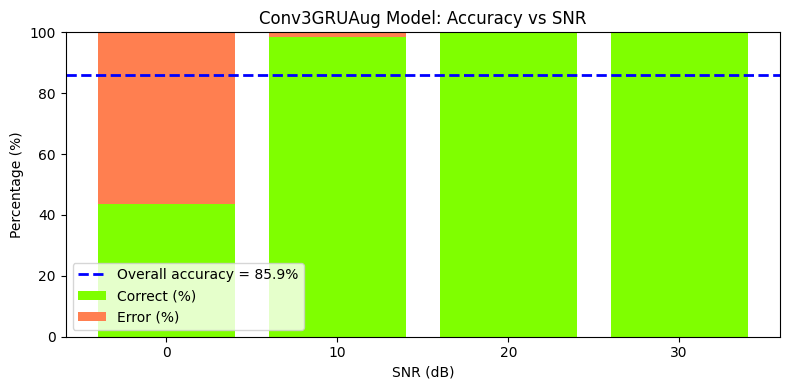

In [51]:
# Conv3GRUAug model
snrs_results, cms, overall_acc = snr_accuracy_summary((y_true, y_pred), test_snr, labels_dict=labels_dict, n_classes=6, plot=True, return_cms=True, title="Conv3GRUAug Model: Accuracy vs SNR")  

<h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>

We see that the accuracy is almost 100% when the SNR is equal or above 10dB, but the classifiers perform poorly on highly noised signals. 

The Conv3GRUAug is a little better than the Conv3 model on the 10dB signals.

<hr style="border:10px solid blue"> </hr>
</font></h4>

### 3.3 Confusion matrix for differents SNRs (Conv3GRUAug)


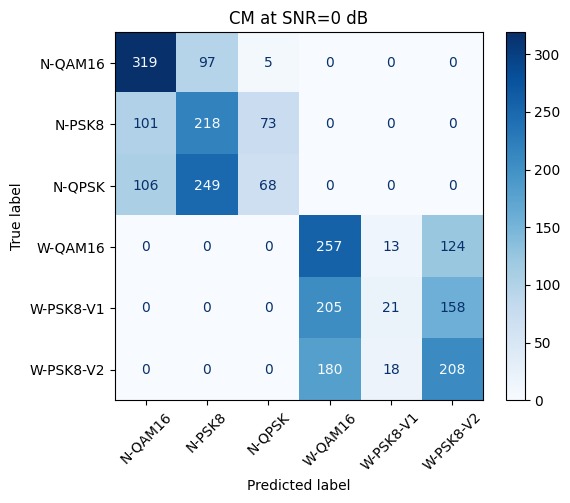

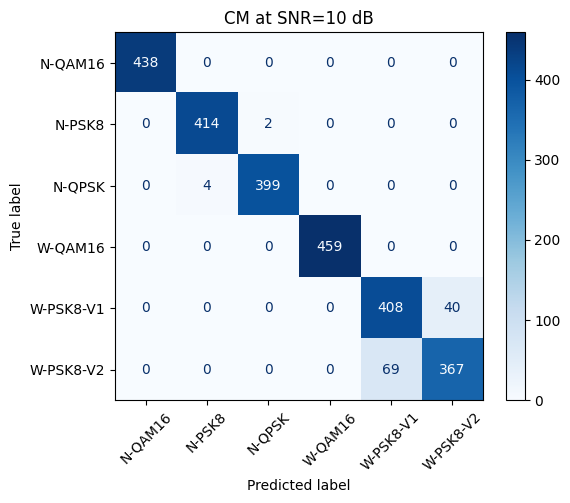

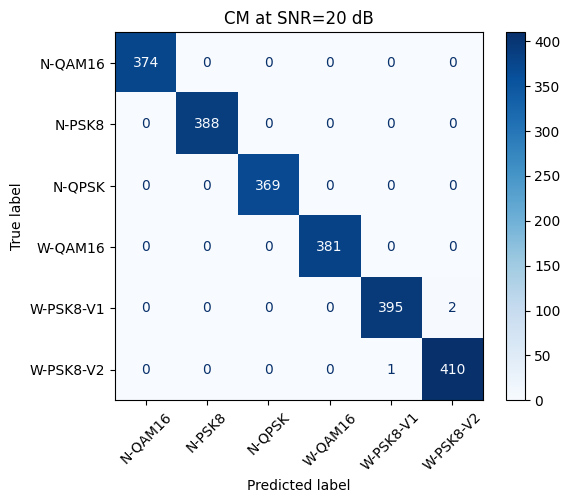

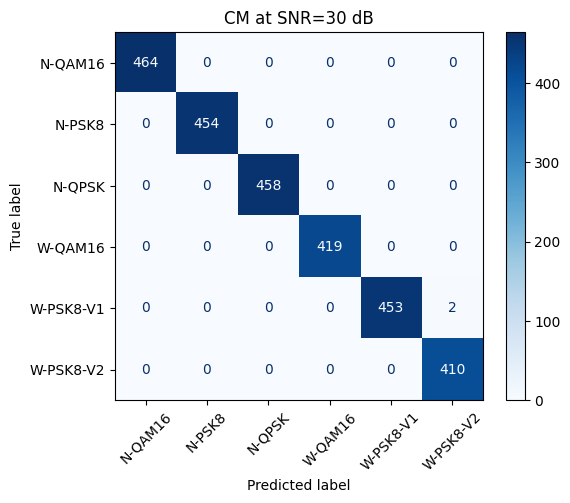

In [42]:
n_classes = len(labels_dict)
for cm, snr_level in zip(cms, snr_levels):
    plt.figure(figsize=(6, 5))
    plt.title(f"CM at SNR={snr_level} dB")
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, [labels_dict[i] for i in range(n_classes)], rotation=45)
    plt.yticks(tick_marks, [labels_dict[i] for i in range(n_classes)])

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[labels_dict[i] for i in range(n_classes)])
    disp.plot(ax=plt.gca(), cmap=plt.cm.Blues, values_format='d', xticks_rotation=45)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
            

### 3.4 Inference time and throughput for 3 models (Conv2, Conv3, Conv3GRU)

Timing device: mps
Batch size for timing: 8 input shape: (8, 2, 2048)
Warning loading conv2_model.pth: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.ConvModel2 was not an allowed global by default. Please use `torch.serialization.add_safe_globals([__main__.ConvModel2])` or the `torch.serialization.safe_globals([__main__.ConvModel2])` context manager to allowlist this global if you trust this class/function.


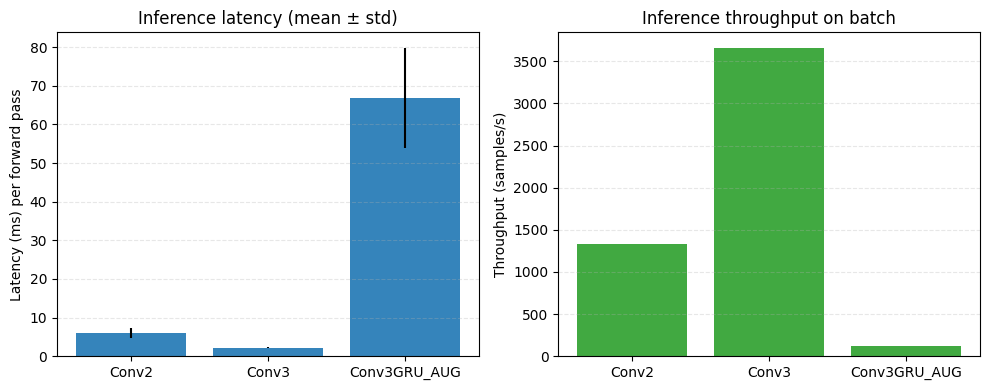

In [26]:
import time
import numpy as np
import matplotlib.pyplot as plt

# Configure device
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print("Timing device:", device)

# Load one batch to use for timing (reuse test_loader if present)
try:
    xb, yb = next(iter(test_loader))
except Exception:
    # fallback: build a random batch with the same shape as sample dataset
    sample = dataset[0][0]
    batch_size = 8
    xb = torch.stack([sample.clone() for _ in range(batch_size)], dim=0)
    yb = torch.zeros(batch_size, dtype=torch.long)

xb = xb.to(device)
batch_size = xb.size(0)
print("Batch size for timing:", batch_size, "input shape:", tuple(xb.shape))

# Instantiate models and corresponding checkpoint paths
models_info = [
    ("Conv2", ConvModel2(in_channels=2, n_classes=6), "conv2_model.pth"),
    ("Conv3", Conv3Model(in_channels=2, n_classes=6), "conv3_model.pth"),
    ("Conv3GRU_AUG", Conv3GRUModel(in_channels=2, n_classes=6), "conv3_gru_aug_model.pth"),
]

results = []

def _synchronize(device):
    if device.startswith("cuda"):
        torch.cuda.synchronize()
    else:
        try:
            # available in recent PyTorch for Apple Silicon
            if device.startswith("mps"):
                torch.mps.synchronize()
        except Exception:
            pass

def time_model(model, inp, n_warmup=10, n_iter=60):
    model.to(device)
    model.eval()
    # warmup
    with torch.no_grad():
        for _ in range(n_warmup):
            _ = model(inp)
            _synchronize(device)
    # measure
    timings = []
    with torch.no_grad():
        for _ in range(n_iter):
            _synchronize(device)
            t0 = time.perf_counter()
            _ = model(inp)
            _synchronize(device)
            t1 = time.perf_counter()
            timings.append(t1 - t0)
    arr = np.array(timings)
    return float(arr.mean()), float(arr.std())

for name, model_obj, ckpt in models_info:
    try:
        state = torch.load(ckpt, map_location=device)
        # handle both state_dict and full model saved cases
        if isinstance(state, dict) and all(k.startswith('_') for k in state.keys()) == False and any(k.startswith('conv') or k.endswith('weight') for k in state.keys()):
            model_obj.load_state_dict(state)
        else:
            # if full model saved with torch.save(model), try load_state_dict anyway
            try:
                model_obj.load_state_dict(state)
            except Exception:
                # last resort: torch.load returned a module
                model_obj = state
        model_obj.to(device)
    except FileNotFoundError:
        print(f"Warning: checkpoint {ckpt} not found. Using randomly initialized weights for {name}.")
    except Exception as e:
        print(f"Warning loading {ckpt}: {e}. Proceeding with current instance.")

    mean_s, std_s = time_model(model_obj, xb, n_warmup=10, n_iter=80)
    ms_mean = mean_s * 1000.0
    ms_std = std_s * 1000.0
    throughput = batch_size / mean_s
    results.append((name, ms_mean, ms_std, throughput))
    print(f"{name}: {ms_mean:.2f} ms ± {ms_std:.2f} ms → {throughput:.1f} samples/s")

# Plot results
names = [r[0] for r in results]
lat_means = [r[1] for r in results]
lat_stds = [r[2] for r in results]
throughputs = [r[3] for r in results]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar(names, lat_means, yerr=lat_stds, color='tab:blue', alpha=0.9)
plt.ylabel("Latency (ms) per forward pass")
plt.title("Inference latency (mean ± std)")
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.subplot(1,2,2)
plt.bar(names, throughputs, color='tab:green', alpha=0.9)
plt.ylabel("Throughput (samples/s)")
plt.title("Inference throughput on batch")
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


## 4. Conclusions

Number of parameters in ConvModel: 10166 <br>
Number of parameters in Conv2Model: 80998 <br>
Number of parameters in Conv3Model: 81446 <br>
Number of parameters in Conv3GRUModel: 155942 <br>

<h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>

We have seen different architectures for this classification task. **The purely convolutional Conv3 model is the best compromise of performance vs. complexity / inference time / time to engineer.** 

To get further in terms of classification, we need to find a way to handle the 0dB signals as they drop the performance of the overall classifier. One stragegy could be to design a classifier to classify noisy vs. non noisy signals and train a more specific classifier of solely noisy signals together. The signal is first classified as noisy vs. non-noisy and then redirected to the wright classifier in consequence. This could increase the performance of the individuals classifiers but increase also the overall inference time. 

<hr style="border:10px solid blue"> </hr>
</font></h4>